In [ ]:
# The relevant part for the project thesis starts in PROJECT TVT
# SEARCH FOR " PROJECT TVT "

In [1]:
from tcrpeg.TCRpeg import TCRpeg
# from tcrpeg.classification import classification
import pandas as pd
import numpy as np
# import os
# from tcrpeg.evaluate import evaluation
# from tcrpeg.utils import plotting
from tcrpeg.word2vec import word2vec
# import warnings
# warnings.filterwarnings('ignore')
import torch
import pickle

In [2]:

if torch.cuda.is_available():
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU available")


GPU is available: Tesla T4


In [5]:
torch.cuda.empty_cache()

In [6]:
# In this section will be the IEDB 

path_to_IEDB = "/home/ubuntu/PA-Cancer-Immunotherapy/GNN/processed_data/IEDB/IEDB.csv"
df = pd.read_csv(path_to_IEDB)
print('Satarting length= ', len(df))
df = df[df['CDR3.beta'].apply(len) <= 30] 
print('Length after removing len > 30 = ', len(df))
# prov_df = df[df['CDR3.beta'].apply(len) <= 2] 
# print(len(prov_df))
unique_chars = set(''.join(df['CDR3.beta']))  
# print("Unique characters in sequences:", unique_chars)

df_train = df['CDR3.beta'].values
#create the TCRpeg class
model = TCRpeg(hidden_size=64,num_layers = 3,load_data=True,embedding_path='TCRpeg/tcrpeg/data/embedding_32.txt',path_train=df_train)
#create the TCRpeg model. 
model.create_model()

unmapped_chars = [ch for ch in unique_chars if ch not in model.aa2idx]
print("Unmapped characters:", unmapped_chars)


# Create a regex pattern to match any of these characters
pattern = f"[{''.join(unmapped_chars)}]"

# Remove rows with any of the unmapped characters in 'CDR3.beta' column
df = df[~df['CDR3.beta'].str.contains(pattern)]
print('Length after removing unmapped chars= ', len(df))

df_train = df['CDR3.beta'].values
#create the TCRpeg class
model = TCRpeg(hidden_size=256,num_layers = 3,load_data=True,embedding_path='TCRpeg/tcrpeg/data/embedding_32.txt',path_train=df_train)
#create the TCRpeg model. 
model.create_model()

Satarting length=  175560
Length after removing len > 30 =  175557
Have loaded the data, total training seqs : 175557
Unmapped characters: ['l', 'X', 'i']
Length after removing unmapped chars=  175545
Have loaded the data, total training seqs : 175545


In [8]:
df_train[:10]

array(['ASSQGGDRGDPGDGYT', 'CASRPGLAGGRPEQYF', 'CASRPGLMSAQPEQYF',
       'CASSYVGNTGELFF', 'SARDGTGNGYT', 'CAISEVGVGQPQHF',
       'CAISEVGVGQPQHF', 'CAISEVGVGQPQHF', 'ASSFIGGTDTQYF',
       'ASSKTSGSPYNEQF'], dtype=object)

In [5]:
# create embeddings for allele and gene (this is only for test.tsv).  This time save as a dictionary 
# File paths
file_paths = [
    "../data_for_inference/allele/beta/test.tsv",
    "../data_for_inference/gene/beta/test.tsv"
]
precisions = ['allele', 'gene']

# Load, process, and split each file
for k, file_path in enumerate(file_paths):
    print(f"Processing {file_path}")
    
    # 1. Load the .tsv file
    df = pd.read_csv(file_path, sep='\t')
    
    # 2. Delete specific columns (replace 'column_to_delete' with actual column names)
    columns_to_delete = ['TCR_name', 'TRBV', 'TRBJ', 'TRBC', 'MHC', 'task']
    df.drop(columns=columns_to_delete, inplace=True, errors='ignore')
    
    # 3. Rename columns (replace with actual mappings)
    columns_to_rename = {
        'TRB_CDR3': 'CDR3.beta',
        'Binding': 'Label'
    }
    df.rename(columns=columns_to_rename, inplace=True)

    print('Satarting length= ', len(df))
    df = df[df['CDR3.beta'].apply(len) <= 30] 
    print('Length after removing CDR3.beta len > 30 = ', len(df))
    df = df[df['Epitope'].apply(len) <= 30] 
    print('Length after removing Epitope len > 30 = ', len(df))
    

    unique_chars = set(''.join(df['CDR3.beta']))  # Replace 'sequence_column' with your actual column name
    # print("Unique characters in sequences:", unique_chars)
    
    df_train = df['CDR3.beta'].values
    #create the TCRpeg class
    model = TCRpeg(hidden_size=64,num_layers = 3, load_data=True, embedding_path='TCRpeg/tcrpeg/data/embedding_32.txt', path_train=df_train)
    #create the TCRpeg model. 
    model.create_model()
    
    unmapped_chars = [ch for ch in unique_chars if ch not in model.aa2idx]
    print("Unmapped characters:", unmapped_chars)
    if unmapped_chars:
        
        # Create a regex pattern to match any of these characters
        pattern = f"[{''.join(unmapped_chars)}]"
        
        # Remove rows with any of the unmapped characters in 'CDR3.beta' column
        df = df[~df['CDR3.beta'].str.contains(pattern)]
        print('Length after removing unmapped chars= ', len(df))
    
    # create two dfs: CDR3.beta and Epitope. Make them unique() and create embedding

    df_cdr = df['CDR3.beta']
    df_epit = df['Epitope']
    # here I am... finding out if I can generate embeddings for the epitopes with the same model TCRpeg ------------------------------------
    # apparently yes!

    cdr_epitop_dfs = [df_cdr, df_epit]

    merged_dict = {}
    
    for dataframe in cdr_epitop_dfs:

        df_train = dataframe.unique()
        # Parameters
        batch_size = 10000  # Adjust batch size as needed
        total_sequences = len(df_train)
        num_batches = (total_sequences + batch_size - 1) // batch_size  # Calculate the number of batches needed
        
        # List to store embeddings
        all_embeddings = []
        
        print(f"Total training sequences: {total_sequences}")
        print(f"Processing in {num_batches} batches of {batch_size} sequences each.")


        #create the TCRpeg class
        model = TCRpeg(hidden_size=256,num_layers = 3,load_data=False,embedding_path='TCRpeg/tcrpeg/data/embedding_32.txt')#,path_train=df_train)
        #create the TCRpeg model. 
        model.create_model()
        # Loop through batches
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min(start_idx + batch_size, total_sequences)
            print(f"Processing batch {i+1}/{num_batches}, sequences {start_idx} to {end_idx}")
        
            # Get the batch data and generate embeddings
            batch_embeddings = model.get_embedding(df_train[start_idx:end_idx])
        
            # Append the batch embeddings to the list
            all_embeddings.append(batch_embeddings)
        
        # Concatenate all embeddings into a single array (or DataFrame if needed)
        final_embeddings = np.concatenate(all_embeddings, axis=0)

        dictionary = {}

        for index, element in enumerate(df_train):
            dictionary[element] = final_embeddings[index]

        merged_dict.update(dictionary)

    # save as embedding.pkl
    # Define the path
    # save_path = f"../models/PA/{precisions[k]}_embeddings.pkl"
    # prov_save_path = f"./{precisions[k]}_old_embeddings.pkl"
    prov_save_path = f"./{precisions[k]}_new_embeddings.pkl"

    
    # Save seq_embs to the path
    with open(prov_save_path, "wb") as f:
        pickle.dump(merged_dict, f)
    
    print(f"embeddings dictionary saved to {prov_save_path}")
        


Processing ../data_for_inference/allele/beta/test.tsv
Satarting length=  59798
Length after removing CDR3.beta len > 30 =  59798
Length after removing Epitope len > 30 =  59455
Have loaded the data, total training seqs : 59455
Unmapped characters: []
Total training sequences: 25235
Processing in 3 batches of 10000 sequences each.
Processing batch 1/3, sequences 0 to 10000
Processing batch 2/3, sequences 10000 to 20000
Processing batch 3/3, sequences 20000 to 25235
Total training sequences: 1058
Processing in 1 batches of 10000 sequences each.
Processing batch 1/1, sequences 0 to 1058
embeddings dictionary saved to ./allele_new_embeddings.pkl
Processing ../data_for_inference/gene/beta/test.tsv
Satarting length=  53858
Length after removing CDR3.beta len > 30 =  53858
Length after removing Epitope len > 30 =  53484
Have loaded the data, total training seqs : 53484
Unmapped characters: []
Total training sequences: 21189
Processing in 3 batches of 10000 sequences each.
Processing batch 1/3

In [6]:
# control if the embeddings just created with and without "load_data" are equal.
# update: this comparison does not make sense :))
new = "allele_new_embeddings.pkl"
old = "allele_old_embeddings.pkl"
both = [new, old]
for emb in both:
    # Load the .pkl file
    with open(emb, 'rb') as f:
        embeddings = pickle.load(f)
    
    # Check the type of the loaded object
    print("Type of the object:", type(embeddings))
    
    # Explore the contents of the file
    # If it's a dictionary, you can inspect keys and sample values
    if isinstance(embeddings, dict):
        # print("Number of keys:", len(embeddings))
        print("First few keys:", list(embeddings.keys())[:5])
        print("Sample value for the first key:", embeddings[list(embeddings.keys())[0]])

Type of the object: <class 'dict'>
First few keys: ['CASSTWTVSYEQYF', 'CASSLGGEQYF', 'CASSLGGPYEQYF', 'CASSLTGTEAFF', 'CASSFLSEQYF']
Sample value for the first key: [-1.09079078e-01  4.20350060e-02 -3.18881869e-02  2.45898813e-02
 -3.90989669e-02  1.93683319e-02  1.35620028e-01  1.94600984e-01
 -1.70274660e-01  1.76486466e-02 -1.23516163e-02  4.37802784e-02
 -2.16785707e-02 -1.20165199e-01 -1.79065704e-01  6.28184434e-03
  1.02038160e-01 -2.37312004e-01  1.69295464e-02  1.02269456e-01
 -1.26717344e-01 -2.52092574e-02  5.08086719e-02 -3.90811674e-02
 -3.98867205e-02  2.43063569e-01 -1.81028277e-01  1.63479134e-01
  1.08441927e-01  1.45789653e-01 -3.92839074e-01  1.58200040e-01
  2.22654179e-01 -7.31083155e-02  3.96539979e-02 -1.49502993e-01
  2.86495369e-02  2.18770448e-02  4.62087877e-02  3.46676223e-02
  7.51961442e-03  2.57416517e-01 -6.78399876e-02 -1.67149261e-01
 -2.10601334e-02 -1.60448119e-01 -2.90385187e-02  2.21604168e-01
  2.03427568e-01 -2.17361636e-02 -5.26504777e-02  1.220

In [10]:
print("Shape of seq_embs:", final_embeddings.shape)

Shape of seq_embs: (175545, 768)


In [11]:
import sys

print(f"Memory usage of seq_embs: {sys.getsizeof(final_embeddings)} bytes")


Memory usage of seq_embs: 539274368 bytes


In [7]:
# Create embeddings for the so called PA_all datasets, in order to train a model

# first for allele. 
# Select columns, merge train, test and validation, crate 5 folds from which 4 are for gnn training and one for testing.
paths_allele = ["../data_for_training/splitted_datasets/allele/beta/train.tsv", 
                "../data_for_training/splitted_datasets/allele/beta/validation.tsv",
                "../data_for_training/splitted_datasets/allele/beta/test.tsv"]
allele_dfs = [pd.read_csv(path, sep='\t') for path in paths_allele]  # Load all files into a list of DataFrames
concatenated_df = pd.concat(allele_dfs, ignore_index=True)  # Concatenate them into a single DataFrame
df = concatenated_df[['TRB_CDR3', 'Epitope', 'Binding']] # keep just what is needed

columns_to_rename = {
    'TRB_CDR3': 'CDR3.beta',
    'Binding': 'Label'
}
df.rename(columns=columns_to_rename, inplace=True)
print('Satarting length= ', len(df))
df = df[df['CDR3.beta'].apply(len) <= 30] 
print('Length after removing CDR3.beta len > 30 = ', len(df))
df = df[df['Epitope'].apply(len) <= 30] 
print('Length after removing Epitope len > 30 = ', len(df))

df_train = df['CDR3.beta'].values
#create the TCRpeg class
model = TCRpeg(hidden_size=64,num_layers = 3,load_data=True,embedding_path='TCRpeg/tcrpeg/data/embedding_32.txt',path_train=df_train)
#create the TCRpeg model. 
model.create_model()

# precisions = ['allele', 'gene']  # this might be used for a complete pipeline, but not yet


# create two dfs: CDR3.beta and Epitope. Make them unique() and create embedding

df_cdr = df['CDR3.beta']
df_epit = df['Epitope']

cdr_epitop_dfs = [df_cdr, df_epit]

merged_dict = {}

for dataframe in cdr_epitop_dfs:

    df_train = dataframe.unique()
    # Parameters
    batch_size = 10000  # Adjust batch size as needed
    total_sequences = len(df_train)
    num_batches = (total_sequences + batch_size - 1) // batch_size  # Calculate the number of batches needed
    
    # List to store embeddings
    all_embeddings = []
    
    print(f"Total training sequences: {total_sequences}")
    print(f"Processing in {num_batches} batches of {batch_size} sequences each.")


    #create the TCRpeg class
    model = TCRpeg(hidden_size=256,num_layers = 3,load_data=False,embedding_path='TCRpeg/tcrpeg/data/embedding_32.txt')#,path_train=df_train)
    #create the TCRpeg model. 
    model.create_model()
    # Loop through batches
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, total_sequences)
        print(f"Processing batch {i+1}/{num_batches}, sequences {start_idx} to {end_idx}")
    
        # Get the batch data and generate embeddings
        batch_embeddings = model.get_embedding(df_train[start_idx:end_idx])
    
        # Append the batch embeddings to the list
        all_embeddings.append(batch_embeddings)
    
    # Concatenate all embeddings into a single array (or DataFrame if needed)
    final_embeddings = np.concatenate(all_embeddings, axis=0)

    dictionary = {}

    for index, element in enumerate(df_train):
        dictionary[element] = final_embeddings[index]

    merged_dict.update(dictionary)

# save as embedding.pkl
# Define the path
save_path = f"../models/PA_all/allele_embeddings.pkl"

# Save seq_embs to the path
with open(save_path, "wb") as f:
    pickle.dump(merged_dict, f)

print(f"embeddings dictionary saved to {save_path}")

/tmp/ipykernel_65286/1671728787.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=columns_to_rename, inplace=True)


Satarting length=  398581
Length after removing CDR3.beta len > 30 =  398567
Length after removing Epitope len > 30 =  394570
Have loaded the data, total training seqs : 394570
Total training sequences: 152148
Processing in 16 batches of 10000 sequences each.
Processing batch 1/16, sequences 0 to 10000
Processing batch 2/16, sequences 10000 to 20000
Processing batch 3/16, sequences 20000 to 30000
Processing batch 4/16, sequences 30000 to 40000
Processing batch 5/16, sequences 40000 to 50000
Processing batch 6/16, sequences 50000 to 60000
Processing batch 7/16, sequences 60000 to 70000
Processing batch 8/16, sequences 70000 to 80000
Processing batch 9/16, sequences 80000 to 90000
Processing batch 10/16, sequences 90000 to 100000
Processing batch 11/16, sequences 100000 to 110000
Processing batch 12/16, sequences 110000 to 120000
Processing batch 13/16, sequences 120000 to 130000
Processing batch 14/16, sequences 130000 to 140000
Processing batch 15/16, sequences 140000 to 150000
Process

In [8]:
# Continue creating embeddings for the so called PA_all datasets, in order to train a model

# now for gene. 

# Select columns, merge train, test and validation, crate 5 folds from which 4 are for gnn training and one for testing.
paths_allele = ["../data_for_training/splitted_datasets/gene/beta/train.tsv", 
                "../data_for_training/splitted_datasets/gene/beta/validation.tsv",
                "../data_for_training/splitted_datasets/gene/beta/test.tsv"]
allele_dfs = [pd.read_csv(path, sep='\t') for path in paths_allele]  # Load all files into a list of DataFrames
concatenated_df = pd.concat(allele_dfs, ignore_index=True)  # Concatenate them into a single DataFrame
df = concatenated_df[['TRB_CDR3', 'Epitope', 'Binding']] # keep just what is needed

columns_to_rename = {
    'TRB_CDR3': 'CDR3.beta',
    'Binding': 'Label'
}
df.rename(columns=columns_to_rename, inplace=True)
print('Satarting length= ', len(df))
df = df[df['CDR3.beta'].apply(len) <= 30] 
print('Length after removing CDR3.beta len > 30 = ', len(df))
df = df[df['Epitope'].apply(len) <= 30] 
print('Length after removing Epitope len > 30 = ', len(df))

df_train = df['CDR3.beta'].values
#create the TCRpeg class
model = TCRpeg(hidden_size=64,num_layers = 3,load_data=True,embedding_path='TCRpeg/tcrpeg/data/embedding_32.txt',path_train=df_train)
#create the TCRpeg model. 
model.create_model()

# precisions = ['allele', 'gene']  # this might be used for a complete pipeline, but not yet


# create two dfs: CDR3.beta and Epitope. Make them unique() and create embedding

df_cdr = df['CDR3.beta']
df_epit = df['Epitope']

cdr_epitop_dfs = [df_cdr, df_epit]

merged_dict = {}

for dataframe in cdr_epitop_dfs:

    df_train = dataframe.unique()
    # Parameters
    batch_size = 10000  # Adjust batch size as needed
    total_sequences = len(df_train)
    num_batches = (total_sequences + batch_size - 1) // batch_size  # Calculate the number of batches needed
    
    # List to store embeddings
    all_embeddings = []
    
    print(f"Total training sequences: {total_sequences}")
    print(f"Processing in {num_batches} batches of {batch_size} sequences each.")


    #create the TCRpeg class
    model = TCRpeg(hidden_size=256,num_layers = 3,load_data=False,embedding_path='TCRpeg/tcrpeg/data/embedding_32.txt')#,path_train=df_train)
    #create the TCRpeg model. 
    model.create_model()
    # Loop through batches
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, total_sequences)
        print(f"Processing batch {i+1}/{num_batches}, sequences {start_idx} to {end_idx}")
    
        # Get the batch data and generate embeddings
        batch_embeddings = model.get_embedding(df_train[start_idx:end_idx])
    
        # Append the batch embeddings to the list
        all_embeddings.append(batch_embeddings)
    
    # Concatenate all embeddings into a single array (or DataFrame if needed)
    final_embeddings = np.concatenate(all_embeddings, axis=0)

    dictionary = {}

    for index, element in enumerate(df_train):
        dictionary[element] = final_embeddings[index]

    merged_dict.update(dictionary)

# save as embedding.pkl
# Define the path
save_path = f"../models/PA_all/gene_embeddings.pkl"

# Save seq_embs to the path
with open(save_path, "wb") as f:
    pickle.dump(merged_dict, f)

print(f"embeddings dictionary saved to {save_path}")

/tmp/ipykernel_65286/3026338666.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=columns_to_rename, inplace=True)


Satarting length=  359403
Length after removing CDR3.beta len > 30 =  359395
Length after removing Epitope len > 30 =  355416
Have loaded the data, total training seqs : 355416
Total training sequences: 152153
Processing in 16 batches of 10000 sequences each.
Processing batch 1/16, sequences 0 to 10000
Processing batch 2/16, sequences 10000 to 20000
Processing batch 3/16, sequences 20000 to 30000
Processing batch 4/16, sequences 30000 to 40000
Processing batch 5/16, sequences 40000 to 50000
Processing batch 6/16, sequences 50000 to 60000
Processing batch 7/16, sequences 60000 to 70000
Processing batch 8/16, sequences 70000 to 80000
Processing batch 9/16, sequences 80000 to 90000
Processing batch 10/16, sequences 90000 to 100000
Processing batch 11/16, sequences 100000 to 110000
Processing batch 12/16, sequences 110000 to 120000
Processing batch 13/16, sequences 120000 to 130000
Processing batch 14/16, sequences 130000 to 140000
Processing batch 15/16, sequences 140000 to 150000
Process

In [ ]:
# next attempt creating correct embeddings.
# this time the TCRpeg model will be trained
# Things can be tried/make sure of:
# - If training the TCRpeg, what should be in path_train=df_train?? cdr3 only or cdr3 + epitopes??
# - training the TCERpeg without path_train=df_train.
# - using the tcr pre-trained model for embeddings generation

In [5]:
# first: train tcrpeg_model with path_train=df_train, only cdr3

# for allele. 

# Select columns, merge train, test and validation.
paths_allele = ["../data_for_training/splitted_datasets/allele/beta/train.tsv", 
                "../data_for_training/splitted_datasets/allele/beta/validation.tsv",
                "../data_for_training/splitted_datasets/allele/beta/test.tsv"]
allele_dfs = [pd.read_csv(path, sep='\t') for path in paths_allele]  # Load all files into a list of DataFrames
concatenated_df = pd.concat(allele_dfs, ignore_index=True)  # Concatenate them into a single DataFrame
df = concatenated_df[['TRB_CDR3', 'Epitope', 'Binding']] # keep just what is needed

columns_to_rename = {
    'TRB_CDR3': 'CDR3.beta',
    'Binding': 'Label'
}
df.rename(columns=columns_to_rename, inplace=True)
print('Satarting length= ', len(df))
df = df[df['CDR3.beta'].apply(len) <= 30] 
print('Length after removing CDR3.beta len > 30 = ', len(df))
df = df[df['Epitope'].apply(len) <= 30] 
print('Length after removing Epitope len > 30 = ', len(df))

df_train = df['CDR3.beta'].values


/tmp/ipykernel_72384/3062343993.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=columns_to_rename, inplace=True)


Satarting length=  398581
Length after removing CDR3.beta len > 30 =  398567
Length after removing Epitope len > 30 =  394570


In [7]:
#create the TCRpeg class
model = TCRpeg(hidden_size=256,num_layers = 3,load_data=True,embedding_path='TCRpeg/tcrpeg/data/embedding_32.txt',path_train=df_train)
#create the TCRpeg model. 
model.create_model()
model.train_tcrpeg(epochs=10,batch_size=64,lr=1e-3)

Have loaded the data, total training seqs : 394570
begin the training process
begin epoch : 1


100%|██████████████████████████████████████████| 6165/6165 [00:41<00:00, 147.47it/s]


nll_loss: 19.85846844786855
begin epoch : 2


100%|██████████████████████████████████████████| 6165/6165 [00:39<00:00, 156.53it/s]


nll_loss: 18.998626915033718
begin epoch : 3


100%|██████████████████████████████████████████| 6165/6165 [00:39<00:00, 156.65it/s]


nll_loss: 18.58071798678829
begin epoch : 4


100%|██████████████████████████████████████████| 6165/6165 [00:39<00:00, 156.57it/s]


nll_loss: 18.28044961912305
begin epoch : 5


100%|██████████████████████████████████████████| 6165/6165 [00:39<00:00, 156.37it/s]


nll_loss: 18.069511076036935
begin epoch : 6


100%|██████████████████████████████████████████| 6165/6165 [00:39<00:00, 155.71it/s]


nll_loss: 17.921903569545577
begin epoch : 7


100%|██████████████████████████████████████████| 6165/6165 [00:39<00:00, 154.20it/s]


nll_loss: 17.24303059264691
begin epoch : 8


100%|██████████████████████████████████████████| 6165/6165 [00:39<00:00, 154.46it/s]


nll_loss: 16.86305999276315
begin epoch : 9


100%|██████████████████████████████████████████| 6165/6165 [00:39<00:00, 155.53it/s]


nll_loss: 16.623843504293895
begin epoch : 10


100%|██████████████████████████████████████████| 6165/6165 [00:39<00:00, 154.39it/s]

nll_loss: 16.432483562955213
Done training


In [8]:

path_to_save_model = "model_for_emb_allele_cdr.pth"
model.save(path_to_save_model) #save the TCRpeg model
#model.create_model(load=True,path='path_to_save.pth') #load the model

In [9]:
# create two dfs: CDR3.beta and Epitope. Make them unique() and create embedding

df_cdr = df['CDR3.beta']
df_epit = df['Epitope']

cdr_epitop_dfs = [df_cdr, df_epit]

merged_dict = {}

for dataframe in cdr_epitop_dfs:

    df_train = dataframe.unique()
    # Parameters
    batch_size = 10000  # Adjust batch size as needed
    total_sequences = len(df_train)
    num_batches = (total_sequences + batch_size - 1) // batch_size  # Calculate the number of batches needed
    
    # List to store embeddings
    all_embeddings = []
    
    print(f"Total training sequences: {total_sequences}")
    print(f"Processing in {num_batches} batches of {batch_size} sequences each.")

    # Loop through batches
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, total_sequences)
        print(f"Processing batch {i+1}/{num_batches}, sequences {start_idx} to {end_idx}")
    
        # Get the batch data and generate embeddings
        batch_embeddings = model.get_embedding(df_train[start_idx:end_idx])
    
        # Append the batch embeddings to the list
        all_embeddings.append(batch_embeddings)
    
    # Concatenate all embeddings into a single array (or DataFrame if needed)
    final_embeddings = np.concatenate(all_embeddings, axis=0)

    dictionary = {}

    for index, element in enumerate(df_train):
        dictionary[element] = final_embeddings[index]

    merged_dict.update(dictionary)

# save as embedding.pkl
# Define the path
save_path = f"../models/PA_all/allele_embeddings.pkl"

# Save seq_embs to the path
with open(save_path, "wb") as f:
    pickle.dump(merged_dict, f)

print(f"embeddings dictionary saved to {save_path}")

Total training sequences: 152148
Processing in 16 batches of 10000 sequences each.
Processing batch 1/16, sequences 0 to 10000
Processing batch 2/16, sequences 10000 to 20000
Processing batch 3/16, sequences 20000 to 30000
Processing batch 4/16, sequences 30000 to 40000
Processing batch 5/16, sequences 40000 to 50000
Processing batch 6/16, sequences 50000 to 60000
Processing batch 7/16, sequences 60000 to 70000
Processing batch 8/16, sequences 70000 to 80000
Processing batch 9/16, sequences 80000 to 90000
Processing batch 10/16, sequences 90000 to 100000
Processing batch 11/16, sequences 100000 to 110000
Processing batch 12/16, sequences 110000 to 120000
Processing batch 13/16, sequences 120000 to 130000
Processing batch 14/16, sequences 130000 to 140000
Processing batch 15/16, sequences 140000 to 150000
Processing batch 16/16, sequences 150000 to 152148
Total training sequences: 1855
Processing in 1 batches of 10000 sequences each.
Processing batch 1/1, sequences 0 to 1855
embeddings 

In [17]:
# now for gene. 

# Select columns, merge train, test and validation, crate 5 folds from which 4 are for gnn training and one for testing.
paths_allele = ["../data_for_training/splitted_datasets/gene/beta/train.tsv", 
                "../data_for_training/splitted_datasets/gene/beta/validation.tsv",
                "../data_for_training/splitted_datasets/gene/beta/test.tsv"]
allele_dfs = [pd.read_csv(path, sep='\t') for path in paths_allele]  # Load all files into a list of DataFrames
concatenated_df = pd.concat(allele_dfs, ignore_index=True)  # Concatenate them into a single DataFrame
df = concatenated_df[['TRB_CDR3', 'Epitope', 'Binding']] # keep just what is needed

columns_to_rename = {
    'TRB_CDR3': 'CDR3.beta',
    'Binding': 'Label'
}
df.rename(columns=columns_to_rename, inplace=True)
print('Satarting length= ', len(df))
df = df[df['CDR3.beta'].apply(len) <= 30] 
print('Length after removing CDR3.beta len > 30 = ', len(df))
df = df[df['Epitope'].apply(len) <= 30] 
print('Length after removing Epitope len > 30 = ', len(df))

df_train = df['CDR3.beta'].values

Satarting length=  359403
Length after removing CDR3.beta len > 30 =  359395
Length after removing Epitope len > 30 =  355416


/tmp/ipykernel_83234/993687984.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=columns_to_rename, inplace=True)


In [18]:
#create the TCRpeg class
model = TCRpeg(hidden_size=256,num_layers = 3,load_data=True,embedding_path='TCRpeg/tcrpeg/data/embedding_32.txt',path_train=df_train)
#create the TCRpeg model. 
model.create_model()
model.train_tcrpeg(epochs=10,batch_size=64,lr=1e-3)

path_to_save_model = "model_for_emb_gene_cdr.pth"
model.save(path_to_save_model) #save the TCRpeg model
#model.create_model(load=True,path='path_to_save.pth') #load the model


Have loaded the data, total training seqs : 355416
begin the training process
begin epoch : 1


 37%|█████████████████████████████                                                 | 2068/5553 [00:13<00:22, 152.46it/s]


KeyboardInterrupt: 

In [12]:

# create two dfs: CDR3.beta and Epitope. Make them unique() and create embedding

df_cdr = df['CDR3.beta']
df_epit = df['Epitope']

cdr_epitop_dfs = [df_cdr, df_epit]

merged_dict = {}

for dataframe in cdr_epitop_dfs:

    df_train = dataframe.unique()
    # Parameters
    batch_size = 10000  # Adjust batch size as needed
    total_sequences = len(df_train)
    num_batches = (total_sequences + batch_size - 1) // batch_size  # Calculate the number of batches needed
    
    # List to store embeddings
    all_embeddings = []
    
    print(f"Total training sequences: {total_sequences}")
    print(f"Processing in {num_batches} batches of {batch_size} sequences each.")

    # Loop through batches
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, total_sequences)
        print(f"Processing batch {i+1}/{num_batches}, sequences {start_idx} to {end_idx}")
    
        # Get the batch data and generate embeddings
        batch_embeddings = model.get_embedding(df_train[start_idx:end_idx])
    
        # Append the batch embeddings to the list
        all_embeddings.append(batch_embeddings)
    
    # Concatenate all embeddings into a single array (or DataFrame if needed)
    final_embeddings = np.concatenate(all_embeddings, axis=0)

    dictionary = {}

    for index, element in enumerate(df_train):
        dictionary[element] = final_embeddings[index]

    merged_dict.update(dictionary)

# save as embedding.pkl
# Define the path
save_path = f"../models/PA_all/gene_embeddings.pkl"

# Save seq_embs to the path
with open(save_path, "wb") as f:
    pickle.dump(merged_dict, f)

print(f"embeddings dictionary saved to {save_path}")

Total training sequences: 152153
Processing in 16 batches of 10000 sequences each.
Processing batch 1/16, sequences 0 to 10000
Processing batch 2/16, sequences 10000 to 20000
Processing batch 3/16, sequences 20000 to 30000
Processing batch 4/16, sequences 30000 to 40000
Processing batch 5/16, sequences 40000 to 50000
Processing batch 6/16, sequences 50000 to 60000
Processing batch 7/16, sequences 60000 to 70000
Processing batch 8/16, sequences 70000 to 80000
Processing batch 9/16, sequences 80000 to 90000
Processing batch 10/16, sequences 90000 to 100000
Processing batch 11/16, sequences 100000 to 110000
Processing batch 12/16, sequences 110000 to 120000
Processing batch 13/16, sequences 120000 to 130000
Processing batch 14/16, sequences 130000 to 140000
Processing batch 15/16, sequences 140000 to 150000
Processing batch 16/16, sequences 150000 to 152153
Total training sequences: 1855
Processing in 1 batches of 10000 sequences each.
Processing batch 1/1, sequences 0 to 1855
embeddings 

In [ ]:
# creating embeddings using the tcrpeg pretrained model: it doesn't work, because of dimensions

In [10]:
# let's see if saved trained model contains the embedding of a certain epitope and how does it look like

#create the TCRpeg class
model = TCRpeg(hidden_size=256,num_layers = 3,load_data=False,embedding_path='TCRpeg/tcrpeg/data/embedding_32.txt') #,path_train=df_train)

path_to_load_model = "model_for_emb_gene_cdr.pth"
#create the TCRpeg model. 
model.create_model(load=True,path=path_to_load_model) #load the model
# model.train_tcrpeg(epochs=10,batch_size=64,lr=1e-3)


/home/ubuntu/anaconda3/envs/GTE/lib/python3.11/site-packages/tcrpeg/TCRpeg.py:228: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


In [9]:
common_epi.sample(n=2)

,TCR_name,TRBV,TRBJ,TRB_CDR3,TRBC,Epitope,MHC,Binding,task
129345,129346,TRBV7-6,TRBJ2-1,CASSLASGQGARNEQFF,NaN,IVTDFSVIK,HLA-A,0,NaN
102771,102772,TRBV9,TRBJ2-7,CASSPDAGTGYEQYF,NaN,LLWNGPMAV,HLA-A,1,NaN


In [12]:
model.get_embedding(['LLWNGPMAV'])

array([[-7.85216570e-01,  6.31094992e-01,  2.35016078e-01,
        -9.83729511e-02, -7.39667714e-01,  5.87925375e-01,
        -7.32478499e-01,  6.06099308e-01, -9.98675585e-01,
        -9.99996781e-01,  4.67831552e-01, -9.98403847e-01,
         8.87020648e-01,  5.25133967e-01, -9.47763801e-01,
        -9.77581620e-01, -9.82923985e-01, -7.23200291e-02,
         8.60699117e-01,  8.48303795e-01, -9.61959898e-01,
        -4.74052489e-01, -8.11502635e-02, -3.53634357e-01,
         9.99959290e-01, -3.90902627e-03, -6.96269512e-01,
        -9.72776294e-01, -7.89636493e-01,  9.73960340e-01,
         4.73465383e-01, -9.88809109e-01, -9.79680240e-01,
         7.26701319e-01,  9.23946977e-01, -4.06969432e-03,
        -9.86528635e-01,  2.18541380e-02, -1.83118999e-01,
        -1.74015984e-01, -2.38146350e-01, -2.31340393e-01,
        -4.22951430e-01, -3.71226460e-01, -5.40523008e-02,
        -7.88280725e-01, -2.77024388e-01, -9.66380239e-01,
         9.17906702e-01,  7.09976792e-01,  9.93855000e-0

In [13]:
# compare that embedding with the same epitope's embedding from a model without load
model1 = TCRpeg(hidden_size=256,num_layers = 3,load_data=False,embedding_path='TCRpeg/tcrpeg/data/embedding_32.txt') #,path_train=df_train)
#create the TCRpeg model. 
model1.create_model()
model1.get_embedding(['LLWNGPMAV'])

array([[-8.84848759e-02, -3.18352222e-01, -3.77296835e-01,
         5.90151623e-02,  1.02115758e-01,  1.64442640e-02,
         1.20647885e-01, -6.86427951e-02, -3.86170559e-02,
         3.62379244e-03,  1.89693660e-01, -1.17931962e-01,
        -3.37659568e-02, -7.83235729e-02,  1.34097144e-01,
         3.43728140e-02, -1.16494432e-01, -9.42485631e-02,
        -1.45027921e-01, -9.84232724e-02,  7.99232647e-02,
        -5.60301207e-02,  8.34199041e-02,  4.82110605e-02,
         7.07026422e-02, -7.76285678e-02, -1.55046126e-02,
        -8.83131400e-02, -4.34571365e-03, -3.80032733e-02,
         6.56351000e-02, -1.71394989e-01, -9.62471068e-02,
         9.84187946e-02,  1.69138998e-01, -1.38396487e-01,
         3.44670452e-02, -2.66690589e-02, -6.30024672e-02,
         2.95855757e-02, -1.20205745e-01, -1.60888374e-01,
         1.47508085e-01,  3.06693651e-02, -1.04959488e-01,
         2.99017876e-02, -4.00888473e-02,  9.66574550e-02,
         3.68515588e-02, -1.09782346e-01, -4.48409691e-0

In [25]:
model1.get_embedding(['L'])

array([[-1.69056535e-01, -2.35322684e-01, -2.05159485e-02,
        -1.94119617e-01,  1.87468514e-01,  1.77610710e-01,
         2.49026015e-01, -1.23627335e-02,  4.78684977e-02,
        -1.09219812e-01,  7.37267286e-02, -1.66089296e-01,
        -1.81905851e-01,  1.85597554e-01, -8.62733722e-02,
         2.96012443e-02,  3.27942893e-03,  1.87830940e-01,
        -8.30912217e-03, -1.89744635e-04, -5.84460869e-02,
        -2.25376058e-02, -7.08669275e-02, -4.38229255e-02,
        -2.49590464e-02, -1.55738397e-02,  1.84468195e-01,
        -2.86202393e-02,  6.35954291e-02, -5.83728477e-02,
         5.62948287e-02,  7.98505396e-02,  6.46155626e-02,
         1.60580561e-01,  1.47658512e-01, -1.26346901e-01,
         6.68331534e-02,  1.71157211e-01, -1.14315458e-01,
         3.85735072e-02, -4.24565002e-02, -1.45162931e-02,
         7.47228265e-02, -1.70160253e-02,  1.24839701e-01,
        -1.74947321e-01,  1.79693013e-01,  1.64306730e-01,
         1.44486949e-01,  8.97450969e-02, -1.27297238e-0

In [14]:
# compare that embedding with the same epitope's embedding from a model without load, but with training:  It didn't work, perhaps because
# for training it need the df_train
model2 = TCRpeg(hidden_size=256,num_layers = 3,load_data=False,embedding_path='TCRpeg/tcrpeg/data/embedding_32.txt') #,path_train=df_train)
#create the TCRpeg model. 
model2.create_model()
model2.train_tcrpeg(epochs=10,batch_size=64,lr=1e-3)
model2.get_embedding(['LLWNGPMAV'])

begin the training process


AttributeError: 'TCRpeg' object has no attribute 'aas_seqs_train'

In [19]:
# compare that embedding with the same epitope's embedding from a model WITH load
# the df_train will be done above to spare code
# df_train = df['CDR3.beta'].values
model2 = TCRpeg(hidden_size=256,num_layers = 3,load_data=True,embedding_path='TCRpeg/tcrpeg/data/embedding_32.txt',path_train=df_train)
#create the TCRpeg model. 
model2.create_model()
model2.train_tcrpeg(epochs=10,batch_size=64,lr=1e-3)

Have loaded the data, total training seqs : 355416
begin the training process
begin epoch : 1


100%|██████████████████████████████████████████████████████████████████████████████| 5553/5553 [00:35<00:00, 155.23it/s]


nll_loss: 19.991588389875652
begin epoch : 2


100%|██████████████████████████████████████████████████████████████████████████████| 5553/5553 [00:35<00:00, 157.27it/s]


nll_loss: 19.118847734838397
begin epoch : 3


100%|██████████████████████████████████████████████████████████████████████████████| 5553/5553 [00:35<00:00, 155.19it/s]


nll_loss: 18.738341372871364
begin epoch : 4


100%|██████████████████████████████████████████████████████████████████████████████| 5553/5553 [00:35<00:00, 156.42it/s]


nll_loss: 18.466030548139667
begin epoch : 5


100%|██████████████████████████████████████████████████████████████████████████████| 5553/5553 [00:35<00:00, 154.70it/s]


nll_loss: 18.264474987790496
begin epoch : 6


100%|██████████████████████████████████████████████████████████████████████████████| 5553/5553 [00:35<00:00, 154.71it/s]


nll_loss: 18.119866445346627
begin epoch : 7


100%|██████████████████████████████████████████████████████████████████████████████| 5553/5553 [00:35<00:00, 156.17it/s]


nll_loss: 17.517554808495905
begin epoch : 8


100%|██████████████████████████████████████████████████████████████████████████████| 5553/5553 [00:35<00:00, 155.67it/s]


nll_loss: 17.19395809939546
begin epoch : 9


100%|██████████████████████████████████████████████████████████████████████████████| 5553/5553 [00:35<00:00, 155.50it/s]


nll_loss: 16.98372515811161
begin epoch : 10


100%|██████████████████████████████████████████████████████████████████████████████| 5553/5553 [00:35<00:00, 157.16it/s]

nll_loss: 16.80983852580198
Done training


In [20]:
model2.get_embedding(['LLWNGPMAV'])

array([[ 0.27277794, -0.22655687,  0.9539022 , -0.11888824,  0.9961216 ,
         0.99741083, -0.2650989 ,  0.8006666 , -0.55856407,  0.11881872,
        -0.6031905 ,  0.07749218,  0.31077227, -0.24982128, -0.46794194,
        -0.44450858, -0.20602356,  0.72631747, -0.20546049,  0.7981779 ,
         0.6329081 ,  0.6170477 , -0.5630113 , -0.99971324, -0.03838452,
        -0.51204723, -0.23546717, -0.33060008,  0.5207284 , -0.7355891 ,
        -0.9407233 , -0.9426516 , -0.965317  ,  0.8572757 ,  0.6723453 ,
        -0.07726471,  0.45279968,  0.57432765,  0.08409555,  0.8781494 ,
        -0.9008704 ,  0.5118995 , -0.5865497 ,  0.9503806 , -0.80629   ,
         0.5309156 ,  0.6936289 ,  0.95004827,  0.75266933,  0.66746444,
        -0.8651745 , -0.3560009 , -0.9915475 , -0.963755  , -0.6029365 ,
        -0.93171823, -0.42522123,  0.47991017, -0.2533601 ,  0.77346826,
        -0.10576967,  0.93911636, -0.0892831 , -0.58537185,  0.5120497 ,
        -0.62316453, -0.81095284,  0.1010489 , -0.9

In [26]:
# this could be the ultimative experiment

In [27]:
# create embeddings using both cdr3 and epitopes for df_train, training model

# first for gene

paths_allele = ["../data_for_training/splitted_datasets/gene/beta/train.tsv", 
                "../data_for_training/splitted_datasets/gene/beta/validation.tsv",
                "../data_for_training/splitted_datasets/gene/beta/test.tsv"]
allele_dfs = [pd.read_csv(path, sep='\t') for path in paths_allele]  # Load all files into a list of DataFrames
concatenated_df = pd.concat(allele_dfs, ignore_index=True)  # Concatenate them into a single DataFrame
df = concatenated_df[['TRB_CDR3', 'Epitope', 'Binding']] # keep just what is needed

columns_to_rename = {
    'TRB_CDR3': 'CDR3.beta',
    'Binding': 'Label'
}
df.rename(columns=columns_to_rename, inplace=True)
print('Satarting length= ', len(df))
df = df[df['CDR3.beta'].apply(len) <= 30] 
print('Length after removing CDR3.beta len > 30 = ', len(df))
df = df[df['Epitope'].apply(len) <= 30] 
print('Length after removing Epitope len > 30 = ', len(df))

df_train = np.concatenate([df['CDR3.beta'].values, df['Epitope'].values])
# df_train = df['CDR3.beta'].values

#create the TCRpeg class
model = TCRpeg(hidden_size=256,num_layers = 3,load_data=True,embedding_path='TCRpeg/tcrpeg/data/embedding_32.txt',path_train=df_train)
#create the TCRpeg model. 
model.create_model()
model.train_tcrpeg(epochs=15,batch_size=64,lr=1e-3)

path_to_save_model = "model_for_emb_gene_trained_cdr_epi.pth"
model.save(path_to_save_model) #save the TCRpeg model
#model.create_model(load=True,path='path_to_save.pth') #load the model

/tmp/ipykernel_83234/408746154.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=columns_to_rename, inplace=True)


Satarting length=  359403
Length after removing CDR3.beta len > 30 =  359395
Length after removing Epitope len > 30 =  355416
Have loaded the data, total training seqs : 710832
begin the training process
begin epoch : 1


100%|████████████████████████████████████████████████████████████████████████████| 11106/11106 [01:20<00:00, 137.42it/s]


nll_loss: 13.485419980946821
begin epoch : 2


100%|████████████████████████████████████████████████████████████████████████████| 11106/11106 [01:21<00:00, 136.41it/s]


nll_loss: 12.70435786320243
begin epoch : 3


100%|████████████████████████████████████████████████████████████████████████████| 11106/11106 [01:21<00:00, 137.02it/s]


nll_loss: 12.591271745306338
begin epoch : 4


100%|████████████████████████████████████████████████████████████████████████████| 11106/11106 [01:21<00:00, 136.62it/s]


nll_loss: 12.545145575085266
begin epoch : 5


100%|████████████████████████████████████████████████████████████████████████████| 11106/11106 [01:20<00:00, 137.60it/s]


nll_loss: 12.536621701023975
begin epoch : 6


100%|████████████████████████████████████████████████████████████████████████████| 11106/11106 [01:20<00:00, 138.75it/s]


nll_loss: 12.55531702182453
begin epoch : 7


100%|████████████████████████████████████████████████████████████████████████████| 11106/11106 [01:20<00:00, 137.23it/s]


nll_loss: 12.590580910878977
begin epoch : 8


100%|████████████████████████████████████████████████████████████████████████████| 11106/11106 [01:20<00:00, 137.81it/s]


nll_loss: 12.632825985913145
begin epoch : 9


100%|████████████████████████████████████████████████████████████████████████████| 11106/11106 [01:20<00:00, 138.39it/s]


nll_loss: 12.391868168655524
begin epoch : 10


100%|████████████████████████████████████████████████████████████████████████████| 11106/11106 [01:20<00:00, 137.20it/s]


nll_loss: 12.256305477929592
begin epoch : 11


100%|████████████████████████████████████████████████████████████████████████████| 11106/11106 [01:20<00:00, 137.51it/s]


nll_loss: 12.170076192230356
begin epoch : 12


100%|████████████████████████████████████████████████████████████████████████████| 11106/11106 [01:20<00:00, 138.37it/s]


nll_loss: 12.098234577477783
begin epoch : 13


100%|████████████████████████████████████████████████████████████████████████████| 11106/11106 [01:19<00:00, 139.36it/s]


nll_loss: 12.035419071341085
begin epoch : 14


100%|████████████████████████████████████████████████████████████████████████████| 11106/11106 [01:19<00:00, 139.73it/s]


nll_loss: 11.978315262113544
begin epoch : 15


100%|████████████████████████████████████████████████████████████████████████████| 11106/11106 [01:20<00:00, 138.72it/s]


nll_loss: 11.92648029044021
Done training


In [28]:
# create two dfs: CDR3.beta and Epitope. Make them unique() and create embedding

df_cdr = df['CDR3.beta']
df_epit = df['Epitope']

cdr_epitop_dfs = [df_cdr, df_epit]

merged_dict = {}

for dataframe in cdr_epitop_dfs:

    df_train = dataframe.unique()
    # Parameters
    batch_size = 10000  # Adjust batch size as needed
    total_sequences = len(df_train)
    num_batches = (total_sequences + batch_size - 1) // batch_size  # Calculate the number of batches needed
    
    # List to store embeddings
    all_embeddings = []
    
    print(f"Total training sequences: {total_sequences}")
    print(f"Processing in {num_batches} batches of {batch_size} sequences each.")

    # Loop through batches
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, total_sequences)
        print(f"Processing batch {i+1}/{num_batches}, sequences {start_idx} to {end_idx}")
    
        # Get the batch data and generate embeddings
        batch_embeddings = model.get_embedding(df_train[start_idx:end_idx])
    
        # Append the batch embeddings to the list
        all_embeddings.append(batch_embeddings)
    
    # Concatenate all embeddings into a single array (or DataFrame if needed)
    final_embeddings = np.concatenate(all_embeddings, axis=0)

    dictionary = {}

    for index, element in enumerate(df_train):
        dictionary[element] = final_embeddings[index]

    merged_dict.update(dictionary)

# save as embedding.pkl
# Define the path
save_path = f"../models/PA_all/gene_embeddings.pkl"

# Save seq_embs to the path
with open(save_path, "wb") as f:
    pickle.dump(merged_dict, f)

print(f"embeddings dictionary saved to {save_path}")

Total training sequences: 152153
Processing in 16 batches of 10000 sequences each.
Processing batch 1/16, sequences 0 to 10000
Processing batch 2/16, sequences 10000 to 20000
Processing batch 3/16, sequences 20000 to 30000
Processing batch 4/16, sequences 30000 to 40000
Processing batch 5/16, sequences 40000 to 50000
Processing batch 6/16, sequences 50000 to 60000
Processing batch 7/16, sequences 60000 to 70000
Processing batch 8/16, sequences 70000 to 80000
Processing batch 9/16, sequences 80000 to 90000
Processing batch 10/16, sequences 90000 to 100000
Processing batch 11/16, sequences 100000 to 110000
Processing batch 12/16, sequences 110000 to 120000
Processing batch 13/16, sequences 120000 to 130000
Processing batch 14/16, sequences 130000 to 140000
Processing batch 15/16, sequences 140000 to 150000
Processing batch 16/16, sequences 150000 to 152153
Total training sequences: 1855
Processing in 1 batches of 10000 sequences each.
Processing batch 1/1, sequences 0 to 1855
embeddings 

In [2]:
# do the same for allele

# Select columns, merge train, test and validation.
paths_allele = ["../data_for_training/splitted_datasets/allele/beta/train.tsv", 
                "../data_for_training/splitted_datasets/allele/beta/validation.tsv",
                "../data_for_training/splitted_datasets/allele/beta/test.tsv"]
allele_dfs = [pd.read_csv(path, sep='\t') for path in paths_allele]  # Load all files into a list of DataFrames
concatenated_df = pd.concat(allele_dfs, ignore_index=True)  # Concatenate them into a single DataFrame
df = concatenated_df[['TRB_CDR3', 'Epitope', 'Binding']] # keep just what is needed

columns_to_rename = {
    'TRB_CDR3': 'CDR3.beta',
    'Binding': 'Label'
}
df.rename(columns=columns_to_rename, inplace=True)
print('Satarting length= ', len(df))
df = df[df['CDR3.beta'].apply(len) <= 30] 
print('Length after removing CDR3.beta len > 30 = ', len(df))
df = df[df['Epitope'].apply(len) <= 30] 
print('Length after removing Epitope len > 30 = ', len(df))

df_train = np.concatenate([df['CDR3.beta'].values, df['Epitope'].values])
# df_train = df['CDR3.beta'].values

#create the TCRpeg class
model = TCRpeg(hidden_size=256,num_layers = 3,load_data=True,embedding_path='TCRpeg/tcrpeg/data/embedding_32.txt',path_train=df_train)
#create the TCRpeg model. 
model.create_model()
model.train_tcrpeg(epochs=10,batch_size=64,lr=1e-3)

path_to_save_model = "model_for_emb_allele_trained_cdr_epi.pth"
model.save(path_to_save_model) #save the TCRpeg model
#model.create_model(load=True,path='path_to_save.pth') #load the model


/tmp/ipykernel_95461/2301963864.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=columns_to_rename, inplace=True)


Satarting length=  398581
Length after removing CDR3.beta len > 30 =  398567
Length after removing Epitope len > 30 =  394570
Have loaded the data, total training seqs : 789140
begin the training process
begin epoch : 1


100%|████████████████████████████████████████████████████████████████████████████| 12330/12330 [01:29<00:00, 138.17it/s]


nll_loss: 13.413990598448098
begin epoch : 2


100%|████████████████████████████████████████████████████████████████████████████| 12330/12330 [01:28<00:00, 139.16it/s]


nll_loss: 12.669459156785084
begin epoch : 3


100%|████████████████████████████████████████████████████████████████████████████| 12330/12330 [01:28<00:00, 139.75it/s]


nll_loss: 12.566166174518123
begin epoch : 4


100%|████████████████████████████████████████████████████████████████████████████| 12330/12330 [01:28<00:00, 139.95it/s]


nll_loss: 12.537859291500515
begin epoch : 5


100%|████████████████████████████████████████████████████████████████████████████| 12330/12330 [01:28<00:00, 138.71it/s]


nll_loss: 12.542513477869955
begin epoch : 6


100%|████████████████████████████████████████████████████████████████████████████| 12330/12330 [01:29<00:00, 138.51it/s]


nll_loss: 12.57132840036669
begin epoch : 7


100%|████████████████████████████████████████████████████████████████████████████| 12330/12330 [01:28<00:00, 138.72it/s]


nll_loss: 12.307680604212281
begin epoch : 8


100%|████████████████████████████████████████████████████████████████████████████| 12330/12330 [01:29<00:00, 138.12it/s]


nll_loss: 12.156062431675771
begin epoch : 9


100%|████████████████████████████████████████████████████████████████████████████| 12330/12330 [01:28<00:00, 138.92it/s]


nll_loss: 12.053914269836376
begin epoch : 10


100%|████████████████████████████████████████████████████████████████████████████| 12330/12330 [01:29<00:00, 138.29it/s]


nll_loss: 11.969052582297593
Done training


In [3]:
# create two dfs: CDR3.beta and Epitope. Make them unique() and create embedding

df_cdr = df['CDR3.beta']
df_epit = df['Epitope']

cdr_epitop_dfs = [df_cdr, df_epit]

merged_dict = {}

for dataframe in cdr_epitop_dfs:

    df_train = dataframe.unique()
    # Parameters
    batch_size = 10000  # Adjust batch size as needed
    total_sequences = len(df_train)
    num_batches = (total_sequences + batch_size - 1) // batch_size  # Calculate the number of batches needed
    
    # List to store embeddings
    all_embeddings = []
    
    print(f"Total training sequences: {total_sequences}")
    print(f"Processing in {num_batches} batches of {batch_size} sequences each.")

    # Loop through batches
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, total_sequences)
        print(f"Processing batch {i+1}/{num_batches}, sequences {start_idx} to {end_idx}")
    
        # Get the batch data and generate embeddings
        batch_embeddings = model.get_embedding(df_train[start_idx:end_idx])
    
        # Append the batch embeddings to the list
        all_embeddings.append(batch_embeddings)
    
    # Concatenate all embeddings into a single array (or DataFrame if needed)
    final_embeddings = np.concatenate(all_embeddings, axis=0)

    dictionary = {}

    for index, element in enumerate(df_train):
        dictionary[element] = final_embeddings[index]

    merged_dict.update(dictionary)

# save as embedding.pkl
# Define the path
save_path = f"../models/PA_all/allele_embeddings.pkl"

# Save seq_embs to the path
with open(save_path, "wb") as f:
    pickle.dump(merged_dict, f)

print(f"embeddings dictionary saved to {save_path}")

Total training sequences: 152148
Processing in 16 batches of 10000 sequences each.
Processing batch 1/16, sequences 0 to 10000
Processing batch 2/16, sequences 10000 to 20000
Processing batch 3/16, sequences 20000 to 30000
Processing batch 4/16, sequences 30000 to 40000
Processing batch 5/16, sequences 40000 to 50000
Processing batch 6/16, sequences 50000 to 60000
Processing batch 7/16, sequences 60000 to 70000
Processing batch 8/16, sequences 70000 to 80000
Processing batch 9/16, sequences 80000 to 90000
Processing batch 10/16, sequences 90000 to 100000
Processing batch 11/16, sequences 100000 to 110000
Processing batch 12/16, sequences 110000 to 120000
Processing batch 13/16, sequences 120000 to 130000
Processing batch 14/16, sequences 130000 to 140000
Processing batch 15/16, sequences 140000 to 150000
Processing batch 16/16, sequences 150000 to 152148
Total training sequences: 1855
Processing in 1 batches of 10000 sequences each.
Processing batch 1/1, sequences 0 to 1855
embeddings 

In [4]:
# create embeddings using the untrained tcrpeg and compare results in train_pa.py 

# first for gene

paths_allele = ["../data_for_training/splitted_datasets/gene/beta/train.tsv", 
                "../data_for_training/splitted_datasets/gene/beta/validation.tsv",
                "../data_for_training/splitted_datasets/gene/beta/test.tsv"]
allele_dfs = [pd.read_csv(path, sep='\t') for path in paths_allele]  # Load all files into a list of DataFrames
concatenated_df = pd.concat(allele_dfs, ignore_index=True)  # Concatenate them into a single DataFrame
df = concatenated_df[['TRB_CDR3', 'Epitope', 'Binding']] # keep just what is needed

columns_to_rename = {
    'TRB_CDR3': 'CDR3.beta',
    'Binding': 'Label'
}
df.rename(columns=columns_to_rename, inplace=True)
print('Satarting length= ', len(df))
df = df[df['CDR3.beta'].apply(len) <= 30] 
print('Length after removing CDR3.beta len > 30 = ', len(df))
df = df[df['Epitope'].apply(len) <= 30] 
print('Length after removing Epitope len > 30 = ', len(df))

# df_train = np.concatenate([df['CDR3.beta'].values, df['Epitope'].values])
# df_train = df['CDR3.beta'].values

#create the TCRpeg class
model = TCRpeg(hidden_size=256,num_layers = 3,load_data=False,embedding_path='TCRpeg/tcrpeg/data/embedding_32.txt') #,path_train=df_train)
#create the TCRpeg model. 
model.create_model()
model.train_tcrpeg(epochs=15,batch_size=64,lr=1e-3)

path_to_save_model = "model_for_emb_allele_trained_cdr_epi.pth"
model.save(path_to_save_model) #save the TCRpeg model
#model.create_model(load=True,path='path_to_save.pth') #load the model
# path_to_save_model = "model_for_emb_gene_trained_cdr_epi.pth"
# model.save(path_to_save_model) #save the TCRpeg model
#model.create_model(load=True,path='path_to_save.pth') #load the model

# create two dfs: CDR3.beta and Epitope. Make them unique() and create embedding

df_cdr = df['CDR3.beta']
df_epit = df['Epitope']

cdr_epitop_dfs = [df_cdr, df_epit]

merged_dict = {}

for dataframe in cdr_epitop_dfs:

    df_train = dataframe.unique()
    # Parameters
    batch_size = 10000  # Adjust batch size as needed
    total_sequences = len(df_train)
    num_batches = (total_sequences + batch_size - 1) // batch_size  # Calculate the number of batches needed
    
    # List to store embeddings
    all_embeddings = []
    
    print(f"Total training sequences: {total_sequences}")
    print(f"Processing in {num_batches} batches of {batch_size} sequences each.")

    # Loop through batches
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, total_sequences)
        print(f"Processing batch {i+1}/{num_batches}, sequences {start_idx} to {end_idx}")
    
        # Get the batch data and generate embeddings
        batch_embeddings = model.get_embedding(df_train[start_idx:end_idx])
    
        # Append the batch embeddings to the list
        all_embeddings.append(batch_embeddings)
    
    # Concatenate all embeddings into a single array (or DataFrame if needed)
    final_embeddings = np.concatenate(all_embeddings, axis=0)

    dictionary = {}

    for index, element in enumerate(df_train):
        dictionary[element] = final_embeddings[index]

    merged_dict.update(dictionary)

# save as embedding.pkl
# Define the path
save_path = f"../models/PA_all/gene_embeddings.pkl"

# Save seq_embs to the path
with open(save_path, "wb") as f:
    pickle.dump(merged_dict, f)

print(f"embeddings dictionary saved to {save_path}")

# ------------------------------------------------------------------------------------------
# and now for allele


# Select columns, merge train, test and validation.
paths_allele = ["../data_for_training/splitted_datasets/allele/beta/train.tsv", 
                "../data_for_training/splitted_datasets/allele/beta/validation.tsv",
                "../data_for_training/splitted_datasets/allele/beta/test.tsv"]
allele_dfs = [pd.read_csv(path, sep='\t') for path in paths_allele]  # Load all files into a list of DataFrames
concatenated_df = pd.concat(allele_dfs, ignore_index=True)  # Concatenate them into a single DataFrame
df = concatenated_df[['TRB_CDR3', 'Epitope', 'Binding']] # keep just what is needed

columns_to_rename = {
    'TRB_CDR3': 'CDR3.beta',
    'Binding': 'Label'
}
df.rename(columns=columns_to_rename, inplace=True)
print('Satarting length= ', len(df))
df = df[df['CDR3.beta'].apply(len) <= 30] 
print('Length after removing CDR3.beta len > 30 = ', len(df))
df = df[df['Epitope'].apply(len) <= 30] 
print('Length after removing Epitope len > 30 = ', len(df))

# df_train = np.concatenate([df['CDR3.beta'].values, df['Epitope'].values])
# df_train = df['CDR3.beta'].values

#create the TCRpeg class
model = TCRpeg(hidden_size=256,num_layers = 3,load_data=False,embedding_path='TCRpeg/tcrpeg/data/embedding_32.txt') #,path_train=df_train)
#create the TCRpeg model. 
model.create_model()
# model.train_tcrpeg(epochs=10,batch_size=64,lr=1e-3)


df_cdr = df['CDR3.beta']
df_epit = df['Epitope']

cdr_epitop_dfs = [df_cdr, df_epit]

merged_dict = {}

for dataframe in cdr_epitop_dfs:

    df_train = dataframe.unique()
    # Parameters
    batch_size = 10000  # Adjust batch size as needed
    total_sequences = len(df_train)
    num_batches = (total_sequences + batch_size - 1) // batch_size  # Calculate the number of batches needed
    
    # List to store embeddings
    all_embeddings = []
    
    print(f"Total training sequences: {total_sequences}")
    print(f"Processing in {num_batches} batches of {batch_size} sequences each.")

    # Loop through batches
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, total_sequences)
        print(f"Processing batch {i+1}/{num_batches}, sequences {start_idx} to {end_idx}")
    
        # Get the batch data and generate embeddings
        batch_embeddings = model.get_embedding(df_train[start_idx:end_idx])
    
        # Append the batch embeddings to the list
        all_embeddings.append(batch_embeddings)
    
    # Concatenate all embeddings into a single array (or DataFrame if needed)
    final_embeddings = np.concatenate(all_embeddings, axis=0)

    dictionary = {}

    for index, element in enumerate(df_train):
        dictionary[element] = final_embeddings[index]

    merged_dict.update(dictionary)

# save as embedding.pkl
# Define the path
save_path = f"../models/PA_all/allele_embeddings.pkl"

# Save seq_embs to the path
with open(save_path, "wb") as f:
    pickle.dump(merged_dict, f)

print(f"embeddings dictionary saved to {save_path}")


/tmp/ipykernel_95461/138055418.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=columns_to_rename, inplace=True)


Satarting length=  359403
Length after removing CDR3.beta len > 30 =  359395
Length after removing Epitope len > 30 =  355416
Total training sequences: 152153
Processing in 16 batches of 10000 sequences each.
Processing batch 1/16, sequences 0 to 10000
Processing batch 2/16, sequences 10000 to 20000
Processing batch 3/16, sequences 20000 to 30000
Processing batch 4/16, sequences 30000 to 40000
Processing batch 5/16, sequences 40000 to 50000
Processing batch 6/16, sequences 50000 to 60000
Processing batch 7/16, sequences 60000 to 70000
Processing batch 8/16, sequences 70000 to 80000
Processing batch 9/16, sequences 80000 to 90000
Processing batch 10/16, sequences 90000 to 100000
Processing batch 11/16, sequences 100000 to 110000
Processing batch 12/16, sequences 110000 to 120000
Processing batch 13/16, sequences 120000 to 130000
Processing batch 14/16, sequences 130000 to 140000
Processing batch 15/16, sequences 140000 to 150000
Processing batch 16/16, sequences 150000 to 152153
Total t

/tmp/ipykernel_95461/138055418.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=columns_to_rename, inplace=True)


Satarting length=  398581
Length after removing CDR3.beta len > 30 =  398567
Length after removing Epitope len > 30 =  394570
Total training sequences: 152148
Processing in 16 batches of 10000 sequences each.
Processing batch 1/16, sequences 0 to 10000
Processing batch 2/16, sequences 10000 to 20000
Processing batch 3/16, sequences 20000 to 30000
Processing batch 4/16, sequences 30000 to 40000
Processing batch 5/16, sequences 40000 to 50000
Processing batch 6/16, sequences 50000 to 60000
Processing batch 7/16, sequences 60000 to 70000
Processing batch 8/16, sequences 70000 to 80000
Processing batch 9/16, sequences 80000 to 90000
Processing batch 10/16, sequences 90000 to 100000
Processing batch 11/16, sequences 100000 to 110000
Processing batch 12/16, sequences 110000 to 120000
Processing batch 13/16, sequences 120000 to 130000
Processing batch 14/16, sequences 130000 to 140000
Processing batch 15/16, sequences 140000 to 150000
Processing batch 16/16, sequences 150000 to 152148
Total t

In [ ]:
# IN THIS SECTION: CREATE EMBEDINGS FOR PROJECT TVT 

In [ ]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [ ]:
# Next experiment: 
# generate embeddings with the trained tcrpeg model, but separately for cdr3 and for epitope. 
# In fact I can do one training for cdr3 of both allele and gen and another training for epitopes.
# ADDITIONALY: Only the train and validation datasets form BA will be used, to really be able to compare both.
# CORRECTION to 'ADDITIONALY': we do have to use all the datasets for the embeddings.  
# It is the folds that we have to create with only train and validation from 'BA'. 
# (this is the version of embeddings adopted for the further training and inference. 5.12.2024)

In [27]:

# first for CDR3 of both gene and allele

all_paths = ["../data_for_training/splitted_datasets/gene/beta/train.tsv", 
                "../data_for_training/splitted_datasets/gene/beta/validation.tsv",
             "../data_for_training/splitted_datasets/gene/beta/test.tsv",
                "../data_for_training/splitted_datasets/allele/beta/train.tsv", 
                "../data_for_training/splitted_datasets/allele/beta/validation.tsv",
            "../data_for_training/splitted_datasets/allele/beta/test.tsv"]
allele_dfs = [pd.read_csv(path, sep='\t') for path in all_paths]  # Load all files into a list of DataFrames
concatenated_df = pd.concat(allele_dfs, ignore_index=True)  # Concatenate them into a single DataFrame
df = concatenated_df[['TRB_CDR3', 'Epitope', 'Binding']] # keep just what is needed

columns_to_rename = {
    'TRB_CDR3': 'CDR3.beta',
    'Binding': 'Label'
}
df.rename(columns=columns_to_rename, inplace=True)
print('Satarting length= ', len(df))
df = df[df['CDR3.beta'].apply(len) <= 30] 
print('Length after removing CDR3.beta len > 30 = ', len(df))
df = df[df['Epitope'].apply(len) <= 30] 
print('Length after removing Epitope len > 30 = ', len(df))

# ----------------------------------------------------------------------------------
#  First for cdr3. Train TCRpeg

# df_train = np.concatenate([df['CDR3.beta'].values, df['Epitope'].values])
df_train = df['CDR3.beta'].values

#create the TCRpeg class
model = TCRpeg(hidden_size=256, num_layers = 3, load_data=True, embedding_path='TCRpeg/tcrpeg/data/embedding_32.txt', path_train=df_train)
#create the TCRpeg model. 
model.create_model()
model.train_tcrpeg(epochs=12,batch_size=64,lr=1e-3)

path_to_save_model = "model_for_emb_both_trained_only_cdr.pth"
model.save(path_to_save_model) #save the TCRpeg model
#model.create_model(load=True,path='path_to_save.pth') #load the model


df_cdr = df['CDR3.beta']

df_epit = df['Epitope']

# cdr_epitop_dfs = [df_cdr, df_epit]

merged_dict = {}

df_train = df_cdr.unique()
# Parameters
batch_size = 10000  # Adjust batch size as needed
total_sequences = len(df_train)
num_batches = (total_sequences + batch_size - 1) // batch_size  # Calculate the number of batches needed

# List to store embeddings
all_embeddings = []

print(f"Total training sequences: {total_sequences}")
print(f"Processing in {num_batches} batches of {batch_size} sequences each.")

# Loop through batches
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min(start_idx + batch_size, total_sequences)
    print(f"Processing batch {i+1}/{num_batches}, sequences {start_idx} to {end_idx}")

    # Get the batch data and generate embeddings
    batch_embeddings = model.get_embedding(df_train[start_idx:end_idx])

    # Append the batch embeddings to the list
    all_embeddings.append(batch_embeddings)

# Concatenate all embeddings into a single array (or DataFrame if needed)
final_embeddings = np.concatenate(all_embeddings, axis=0)

dictionary = {}

for index, element in enumerate(df_train):
    dictionary[element] = final_embeddings[index]

merged_dict.update(dictionary)

# --------------------------------------------------------------

# Now for Epitopes

# train the TCRpeg model with epitopes
df_train = df['Epitope'].values

#create the TCRpeg class
model = TCRpeg(hidden_size=256, num_layers = 3, load_data=True, embedding_path='TCRpeg/tcrpeg/data/embedding_32.txt', path_train=df_train)
#create the TCRpeg model. 
model.create_model()
model.train_tcrpeg(epochs=12,batch_size=64,lr=1e-3)

path_to_save_model = "model_for_emb_both_trained_only_epi.pth"
model.save(path_to_save_model) #save the TCRpeg model
#model.create_model(load=True,path='path_to_save.pth') #load the model

# generate embeddings fpr epitope
df_train = df_epit.unique()
# Parameters
batch_size = 10000  # Adjust batch size as needed
total_sequences = len(df_train)
num_batches = (total_sequences + batch_size - 1) // batch_size  # Calculate the number of batches needed

# List to store embeddings
all_embeddings = []

print(f"Total training sequences: {total_sequences}")
print(f"Processing in {num_batches} batches of {batch_size} sequences each.")

# Loop through batches
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min(start_idx + batch_size, total_sequences)
    print(f"Processing batch {i+1}/{num_batches}, sequences {start_idx} to {end_idx}")

    # Get the batch data and generate embeddings
    batch_embeddings = model.get_embedding(df_train[start_idx:end_idx])

    # Append the batch embeddings to the list
    all_embeddings.append(batch_embeddings)

# Concatenate all embeddings into a single array (or DataFrame if needed)
final_embeddings = np.concatenate(all_embeddings, axis=0)

dictionary = {}

for index, element in enumerate(df_train):
    dictionary[element] = final_embeddings[index]

merged_dict.update(dictionary)


# save as embedding.pkl
# Define the path
save_path = f"../models/PA_all/gene_and_allele_embeddings.pkl"

# Save seq_embs to the path
with open(save_path, "wb") as f:
    pickle.dump(merged_dict, f)

print(f"embeddings dictionary saved to {save_path}")


/tmp/ipykernel_80647/1915903045.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=columns_to_rename, inplace=True)


Satarting length=  757984
Length after removing CDR3.beta len > 30 =  757962
Length after removing Epitope len > 30 =  749986
Have loaded the data, total training seqs : 749986
begin the training process
begin epoch : 1


100%|████████████████████████████████████████████████████████████████████████████| 11718/11718 [01:17<00:00, 150.83it/s]


nll_loss: 19.45242837794223
begin epoch : 2


100%|████████████████████████████████████████████████████████████████████████████| 11718/11718 [01:17<00:00, 151.13it/s]


nll_loss: 18.481706327251818
begin epoch : 3


100%|████████████████████████████████████████████████████████████████████████████| 11718/11718 [01:15<00:00, 155.28it/s]


nll_loss: 18.094116415052127
begin epoch : 4


100%|████████████████████████████████████████████████████████████████████████████| 11718/11718 [01:15<00:00, 154.42it/s]


nll_loss: 17.927308854358476
begin epoch : 5


100%|████████████████████████████████████████████████████████████████████████████| 11718/11718 [01:18<00:00, 150.23it/s]


nll_loss: 17.88776534888337
begin epoch : 6


100%|████████████████████████████████████████████████████████████████████████████| 11718/11718 [01:19<00:00, 148.01it/s]


nll_loss: 17.931033220077907
begin epoch : 7


100%|████████████████████████████████████████████████████████████████████████████| 11718/11718 [01:17<00:00, 150.72it/s]


nll_loss: 18.018529099599352
begin epoch : 8


100%|████████████████████████████████████████████████████████████████████████████| 11718/11718 [01:17<00:00, 150.36it/s]


nll_loss: 17.383345227942243
begin epoch : 9


100%|████████████████████████████████████████████████████████████████████████████| 11718/11718 [01:18<00:00, 149.16it/s]


nll_loss: 16.83642182315163
begin epoch : 10


100%|████████████████████████████████████████████████████████████████████████████| 11718/11718 [01:19<00:00, 147.48it/s]


nll_loss: 16.4864494642273
begin epoch : 11


100%|████████████████████████████████████████████████████████████████████████████| 11718/11718 [01:18<00:00, 148.62it/s]


nll_loss: 16.22195612177708
begin epoch : 12


100%|████████████████████████████████████████████████████████████████████████████| 11718/11718 [01:17<00:00, 151.35it/s]


nll_loss: 16.013547490493167
Done training
Total training sequences: 152155
Processing in 16 batches of 10000 sequences each.
Processing batch 1/16, sequences 0 to 10000
Processing batch 2/16, sequences 10000 to 20000
Processing batch 3/16, sequences 20000 to 30000
Processing batch 4/16, sequences 30000 to 40000
Processing batch 5/16, sequences 40000 to 50000
Processing batch 6/16, sequences 50000 to 60000
Processing batch 7/16, sequences 60000 to 70000
Processing batch 8/16, sequences 70000 to 80000
Processing batch 9/16, sequences 80000 to 90000
Processing batch 10/16, sequences 90000 to 100000
Processing batch 11/16, sequences 100000 to 110000
Processing batch 12/16, sequences 110000 to 120000
Processing batch 13/16, sequences 120000 to 130000
Processing batch 14/16, sequences 130000 to 140000
Processing batch 15/16, sequences 140000 to 150000
Processing batch 16/16, sequences 150000 to 152155
Have loaded the data, total training seqs : 749986
begin the training process
begin epoch 

100%|████████████████████████████████████████████████████████████████████████████| 11718/11718 [01:26<00:00, 136.08it/s]


nll_loss: 5.118018794556204
begin epoch : 2


100%|████████████████████████████████████████████████████████████████████████████| 11718/11718 [01:26<00:00, 135.85it/s]


nll_loss: 4.5470134694129865
begin epoch : 3


100%|████████████████████████████████████████████████████████████████████████████| 11718/11718 [01:26<00:00, 135.14it/s]


nll_loss: 4.535685412935439
begin epoch : 4


100%|████████████████████████████████████████████████████████████████████████████| 11718/11718 [01:27<00:00, 133.94it/s]


nll_loss: 4.540277630441688
begin epoch : 5


100%|████████████████████████████████████████████████████████████████████████████| 11718/11718 [01:26<00:00, 134.83it/s]


nll_loss: 4.551430093385514
begin epoch : 6


100%|████████████████████████████████████████████████████████████████████████████| 11718/11718 [01:25<00:00, 137.03it/s]


nll_loss: 4.566314344907462
begin epoch : 7


100%|████████████████████████████████████████████████████████████████████████████| 11718/11718 [01:25<00:00, 136.35it/s]


nll_loss: 4.5832116147279125
begin epoch : 8


100%|████████████████████████████████████████████████████████████████████████████| 11718/11718 [01:26<00:00, 135.72it/s]


nll_loss: 4.460685314894496
begin epoch : 9


100%|████████████████████████████████████████████████████████████████████████████| 11718/11718 [01:26<00:00, 136.13it/s]


nll_loss: 4.43313338356145
begin epoch : 10


100%|████████████████████████████████████████████████████████████████████████████| 11718/11718 [01:26<00:00, 135.74it/s]


nll_loss: 4.42612017000631
begin epoch : 11


100%|████████████████████████████████████████████████████████████████████████████| 11718/11718 [01:26<00:00, 135.22it/s]


nll_loss: 4.422020983545421
begin epoch : 12


100%|████████████████████████████████████████████████████████████████████████████| 11718/11718 [01:26<00:00, 135.08it/s]


nll_loss: 4.4205998270803395
Done training
Total training sequences: 1855
Processing in 1 batches of 10000 sequences each.
Processing batch 1/1, sequences 0 to 1855
embeddings dictionary saved to ../models/PA_all/gene_and_allele_embeddings.pkl


In [ ]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [ ]:
# let's check the 10_x datasets

In [1]:
import pandas as pd
all_10_x_paths = ["../data_for_training/splitted_datasets/gene/beta/train_10x.tsv", 
                "../data_for_training/splitted_datasets/gene/beta/validation_10x.tsv",
             "../data_for_training/splitted_datasets/gene/beta/test_10x.tsv",
                "../data_for_training/splitted_datasets/allele/beta/train_10x.tsv", 
                "../data_for_training/splitted_datasets/allele/beta/validation_10x.tsv",
            "../data_for_training/splitted_datasets/allele/beta/test_10x.tsv"]

all_ba_paths = ["../data_for_training/splitted_datasets/gene/beta/train.tsv", 
                "../data_for_training/splitted_datasets/gene/beta/validation.tsv",
             "../data_for_training/splitted_datasets/gene/beta/test.tsv",
                "../data_for_training/splitted_datasets/allele/beta/train.tsv", 
                "../data_for_training/splitted_datasets/allele/beta/validation.tsv",
            "../data_for_training/splitted_datasets/allele/beta/test.tsv"]

paths = [all_ba_paths, all_10_x_paths]
for type_df in paths:
    print(f'Processing: {type_df}')
    for path in type_df:
        df = pd.read_csv(path, sep='\t')
        df = df[['TRB_CDR3', 'Epitope', 'Binding']]
        columns_to_rename = {
            'TRB_CDR3': 'CDR3.beta',
            'Binding': 'Label'}
        df.rename(columns=columns_to_rename, inplace=True)
        print(f'Satarting length of {path} ', len(df))
        df = df[df['CDR3.beta'].apply(len) <= 30] 
        print('Length after removing CDR3.beta len > 30 = ', len(df))
        df = df[df['Epitope'].apply(len) <= 30] 
        print('Length after removing Epitope len > 30 = ', len(df))
        

In [2]:
all_dfs[0].head()

,TCR_name,TRBV,TRBJ,TRB_CDR3,TRBC,Epitope,MHC,Binding,task,source
0,51635,TRBV13,TRBJ2-3,CASSPRTGGITDTQYF,NaN,FLNGSCGSV,NaN,1,NaN,10X
1,61063,TRBV6-6,TRBJ2-7,CASSREGAVYEQYF,NaN,YEQYIKWPWYI,NaN,1,NaN,10X
2,CTTAACTAGCCGGTAA-9,TRBV5-1,TRBJ2-7,CASSLEDSRRDEQYV,TRBC2,RIAAWMATY,HLA-A*03:01,0,NaN,BA
3,234400,TRBV5-1,TRBJ1-1,CASSLAGGALAEAFF,NaN,TPRVTGGGAM,HLA-B,0,NaN,10X
4,75878,TRBV29-1,TRBJ2-1,CSVETSGSVYEQFF,NaN,GLCTLVAML,HLA-A,1,NaN,BA


In [ ]:
# it looks ok.  
# Create embeddings:

In [7]:

all_10_x_paths = ["../data_for_training/splitted_datasets/gene/beta/train_10x.tsv", 
                "../data_for_training/splitted_datasets/gene/beta/validation_10x.tsv",
             "../data_for_training/splitted_datasets/gene/beta/test_10x.tsv",
                "../data_for_training/splitted_datasets/allele/beta/train_10x.tsv", 
                "../data_for_training/splitted_datasets/allele/beta/validation_10x.tsv",
            "../data_for_training/splitted_datasets/allele/beta/test_10x.tsv"]
all_dfs = [pd.read_csv(path, sep='\t') for path in all_10_x_paths]  # Load all files into a list of DataFrames
concatenated_df = pd.concat(all_dfs, ignore_index=True)  # Concatenate them into a single DataFrame
df = concatenated_df[['TRB_CDR3', 'Epitope', 'Binding']] # keep just what is needed

columns_to_rename = {
    'TRB_CDR3': 'CDR3.beta',
    'Binding': 'Label'
}
df.rename(columns=columns_to_rename, inplace=True)
print('Satarting length= ', len(df))
df = df[df['CDR3.beta'].apply(len) <= 30] 
print('Length after removing CDR3.beta len > 30 = ', len(df))
df = df[df['Epitope'].apply(len) <= 30] 
print('Length after removing Epitope len > 30 = ', len(df))

# ----------------------------------------------------------------------------------
#  First for cdr3. Train TCRpeg

# df_train = np.concatenate([df['CDR3.beta'].values, df['Epitope'].values])
df_train = df['CDR3.beta'].values

#create the TCRpeg class
model = TCRpeg(hidden_size=256, num_layers = 3, load_data=True, embedding_path='TCRpeg/tcrpeg/data/embedding_32.txt', path_train=df_train)
#create the TCRpeg model. 
model.create_model()

# remove unmapped characters in CDR3.beta column
unique_chars_beta = set(''.join(df['CDR3.beta']))
unmapped_chars_beta = [ch for ch in unique_chars_beta if ch not in model.aa2idx]
print("Unmapped characters in beta:", unmapped_chars_beta)

# Create a regex pattern to match any of these characters
pattern = f"[{''.join(unmapped_chars_beta)}]"

# Remove rows with any of the unmapped characters in 'CDR3.beta' column
df = df[~df['CDR3.beta'].str.contains(pattern)]
print('Length after removing unmapped chars in CDR3.beta= ', len(df))

# the following won't be used because no characters unmapped in Epitope, therefore empty [] in pattern => error.
# # remove unmapped characters in Epitope column
# unique_chars_epi = set(''.join(df['Epitope']))
# unmapped_chars_epi = [ch for ch in unique_chars_epi if ch not in model.aa2idx]
# print("Unmapped characters in epi:", unmapped_chars_epi)

# # Create a regex pattern to match any of these characters
# pattern = f"[{''.join(unmapped_chars_epi)}]"

# # Remove rows with any of the unmapped characters in 'CDR3.beta' column
# df = df[~df['Epitope'].str.contains(pattern)]
# print('Length after removing unmapped chars in Epitope= ', len(df))


# create model again
df_train = df['CDR3.beta'].values
#create the TCRpeg class
model = TCRpeg(hidden_size=256, num_layers = 3, load_data=True, embedding_path='TCRpeg/tcrpeg/data/embedding_32.txt', path_train=df_train)
#create the TCRpeg model. 
model.create_model()
model.train_tcrpeg(epochs=12,batch_size=64,lr=1e-3)

path_to_save_model = "model_for_emb_both_trained_only_cdr_10x.pth"
model.save(path_to_save_model) #save the TCRpeg model
#model.create_model(load=True,path='path_to_save.pth') #load the model


df_cdr = df['CDR3.beta']

df_epit = df['Epitope']

# cdr_epitop_dfs = [df_cdr, df_epit]

merged_dict = {}

df_train = df_cdr.unique()
# Parameters
batch_size = 10000  # Adjust batch size as needed
total_sequences = len(df_train)
num_batches = (total_sequences + batch_size - 1) // batch_size  # Calculate the number of batches needed

# List to store embeddings
all_embeddings = []

print(f"Total training sequences: {total_sequences}")
print(f"Processing in {num_batches} batches of {batch_size} sequences each.")

# Loop through batches
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min(start_idx + batch_size, total_sequences)
    print(f"Processing batch {i+1}/{num_batches}, sequences {start_idx} to {end_idx}")

    # Get the batch data and generate embeddings
    batch_embeddings = model.get_embedding(df_train[start_idx:end_idx])

    # Append the batch embeddings to the list
    all_embeddings.append(batch_embeddings)

# Concatenate all embeddings into a single array (or DataFrame if needed)
final_embeddings = np.concatenate(all_embeddings, axis=0)

dictionary = {}

for index, element in enumerate(df_train):
    dictionary[element] = final_embeddings[index]

merged_dict.update(dictionary)

# --------------------------------------------------------------

# Now for Epitopes

# train the TCRpeg model with epitopes
df_train = df['Epitope'].values

#create the TCRpeg class
model = TCRpeg(hidden_size=256, num_layers = 3, load_data=True, embedding_path='TCRpeg/tcrpeg/data/embedding_32.txt', path_train=df_train)
#create the TCRpeg model. 
model.create_model()
model.train_tcrpeg(epochs=12,batch_size=64,lr=1e-3)

path_to_save_model = "model_for_emb_both_trained_only_epi_10x.pth"
model.save(path_to_save_model) #save the TCRpeg model
#model.create_model(load=True,path='path_to_save.pth') #load the model

# generate embeddings fpr epitope
df_train = df_epit.unique()
# Parameters
batch_size = 10000  # Adjust batch size as needed
total_sequences = len(df_train)
num_batches = (total_sequences + batch_size - 1) // batch_size  # Calculate the number of batches needed

# List to store embeddings
all_embeddings = []

print(f"Total training sequences: {total_sequences}")
print(f"Processing in {num_batches} batches of {batch_size} sequences each.")

# Loop through batches
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min(start_idx + batch_size, total_sequences)
    print(f"Processing batch {i+1}/{num_batches}, sequences {start_idx} to {end_idx}")

    # Get the batch data and generate embeddings
    batch_embeddings = model.get_embedding(df_train[start_idx:end_idx])

    # Append the batch embeddings to the list
    all_embeddings.append(batch_embeddings)

# Concatenate all embeddings into a single array (or DataFrame if needed)
final_embeddings = np.concatenate(all_embeddings, axis=0)

dictionary = {}

for index, element in enumerate(df_train):
    dictionary[element] = final_embeddings[index]

merged_dict.update(dictionary)


# save as embedding.pkl
# Define the path
save_path = f"../models/PA_all/gene_and_allele_embeddings_10x.pkl"

# Save seq_embs to the path
with open(save_path, "wb") as f:
    pickle.dump(merged_dict, f)

print(f"embeddings dictionary saved to {save_path}")

/tmp/ipykernel_48606/260694695.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=columns_to_rename, inplace=True)


Satarting length=  1198496
Length after removing CDR3.beta len > 30 =  1198476
Length after removing Epitope len > 30 =  1191686
Have loaded the data, total training seqs : 1191686
Unmapped characters in beta: ['*']
Length after removing unmapped chars in CDR3.beta=  1187266
Have loaded the data, total training seqs : 1187266
begin the training process
begin epoch : 1


100%|████████████████████████████████████████████████████████████████████████████| 18551/18551 [01:58<00:00, 156.00it/s]


nll_loss: 17.130055234564725
begin epoch : 2


100%|████████████████████████████████████████████████████████████████████████████| 18551/18551 [01:57<00:00, 158.04it/s]


nll_loss: 16.253724413440914
begin epoch : 3


100%|████████████████████████████████████████████████████████████████████████████| 18551/18551 [01:57<00:00, 157.74it/s]


nll_loss: 16.157454978988522
begin epoch : 4


100%|████████████████████████████████████████████████████████████████████████████| 18551/18551 [01:57<00:00, 158.38it/s]


nll_loss: 16.212897160272895
begin epoch : 5


100%|████████████████████████████████████████████████████████████████████████████| 18551/18551 [01:57<00:00, 157.55it/s]


nll_loss: 16.32875261352516
begin epoch : 6


100%|████████████████████████████████████████████████████████████████████████████| 18551/18551 [01:57<00:00, 157.51it/s]


nll_loss: 16.483383709758087
begin epoch : 7


100%|████████████████████████████████████████████████████████████████████████████| 18551/18551 [01:58<00:00, 156.14it/s]


nll_loss: 16.654040141257564
begin epoch : 8


100%|████████████████████████████████████████████████████████████████████████████| 18551/18551 [01:58<00:00, 156.69it/s]


nll_loss: 16.26208769462223
begin epoch : 9


100%|████████████████████████████████████████████████████████████████████████████| 18551/18551 [01:58<00:00, 156.83it/s]


nll_loss: 15.972883481322887
begin epoch : 10


100%|████████████████████████████████████████████████████████████████████████████| 18551/18551 [01:58<00:00, 156.58it/s]


nll_loss: 15.784710459102293
begin epoch : 11


100%|████████████████████████████████████████████████████████████████████████████| 18551/18551 [01:58<00:00, 156.42it/s]


nll_loss: 15.629532638209687
begin epoch : 12


100%|████████████████████████████████████████████████████████████████████████████| 18551/18551 [01:58<00:00, 156.43it/s]


nll_loss: 15.493935049605122
Done training
Total training sequences: 197375
Processing in 20 batches of 10000 sequences each.
Processing batch 1/20, sequences 0 to 10000
Processing batch 2/20, sequences 10000 to 20000
Processing batch 3/20, sequences 20000 to 30000
Processing batch 4/20, sequences 30000 to 40000
Processing batch 5/20, sequences 40000 to 50000
Processing batch 6/20, sequences 50000 to 60000
Processing batch 7/20, sequences 60000 to 70000
Processing batch 8/20, sequences 70000 to 80000
Processing batch 9/20, sequences 80000 to 90000
Processing batch 10/20, sequences 90000 to 100000
Processing batch 11/20, sequences 100000 to 110000
Processing batch 12/20, sequences 110000 to 120000
Processing batch 13/20, sequences 120000 to 130000
Processing batch 14/20, sequences 130000 to 140000
Processing batch 15/20, sequences 140000 to 150000
Processing batch 16/20, sequences 150000 to 160000
Processing batch 17/20, sequences 160000 to 170000
Processing batch 18/20, sequences 17000

100%|████████████████████████████████████████████████████████████████████████████| 18551/18551 [02:04<00:00, 148.87it/s]


nll_loss: 5.203531863316584
begin epoch : 2


100%|████████████████████████████████████████████████████████████████████████████| 18551/18551 [02:05<00:00, 147.30it/s]


nll_loss: 4.850741787192237
begin epoch : 3


100%|████████████████████████████████████████████████████████████████████████████| 18551/18551 [02:05<00:00, 147.25it/s]


nll_loss: 4.856763549959118
begin epoch : 4


100%|████████████████████████████████████████████████████████████████████████████| 18551/18551 [02:05<00:00, 147.70it/s]


nll_loss: 4.875707667906338
begin epoch : 5


100%|████████████████████████████████████████████████████████████████████████████| 18551/18551 [02:06<00:00, 147.20it/s]


nll_loss: 4.902569526032639
begin epoch : 6


100%|████████████████████████████████████████████████████████████████████████████| 18551/18551 [02:06<00:00, 147.08it/s]


nll_loss: 4.941018340671283
begin epoch : 7


100%|████████████████████████████████████████████████████████████████████████████| 18551/18551 [02:05<00:00, 147.87it/s]


nll_loss: 4.985197939799999
begin epoch : 8


100%|████████████████████████████████████████████████████████████████████████████| 18551/18551 [02:05<00:00, 147.56it/s]


nll_loss: 4.818308462023985
begin epoch : 9


100%|████████████████████████████████████████████████████████████████████████████| 18551/18551 [02:06<00:00, 146.78it/s]


nll_loss: 4.772066281610509
begin epoch : 10


100%|████████████████████████████████████████████████████████████████████████████| 18551/18551 [02:07<00:00, 145.87it/s]


nll_loss: 4.758205166904568
begin epoch : 11


100%|████████████████████████████████████████████████████████████████████████████| 18551/18551 [02:06<00:00, 147.16it/s]


nll_loss: 4.750695329285408
begin epoch : 12


100%|████████████████████████████████████████████████████████████████████████████| 18551/18551 [02:05<00:00, 148.34it/s]


nll_loss: 4.745695057303929
Done training
Total training sequences: 1861
Processing in 1 batches of 10000 sequences each.
Processing batch 1/1, sequences 0 to 1861
embeddings dictionary saved to ../models/PA_all/gene_and_allele_embeddings_10x.pkl


In [ ]:
# Length of datasets before and after '>30' and unmapped characters removal
# for table in the project thesis

In [4]:

import pandas as pd



all_10_x_paths = ["../data_for_training/splitted_datasets/gene/beta/train_10x.tsv", 
                "../data_for_training/splitted_datasets/gene/beta/validation_10x.tsv",
             "../data_for_training/splitted_datasets/gene/beta/test_10x.tsv",
                "../data_for_training/splitted_datasets/allele/beta/train_10x.tsv", 
                "../data_for_training/splitted_datasets/allele/beta/validation_10x.tsv",
            "../data_for_training/splitted_datasets/allele/beta/test_10x.tsv"]

all_ba_paths = ["../data_for_training/splitted_datasets/gene/beta/train.tsv", 
                "../data_for_training/splitted_datasets/gene/beta/validation.tsv",
             "../data_for_training/splitted_datasets/gene/beta/test.tsv",
                "../data_for_training/splitted_datasets/allele/beta/train.tsv", 
                "../data_for_training/splitted_datasets/allele/beta/validation.tsv",
            "../data_for_training/splitted_datasets/allele/beta/test.tsv"]

paths = [all_ba_paths, all_10_x_paths]
for type_df in paths:
    
    for path in type_df:
        print(f'Processing: {path}', '\n')
        df = pd.read_csv(path, sep='\t')
        df = df[['TRB_CDR3', 'Epitope', 'Binding']]
        columns_to_rename = {
            'TRB_CDR3': 'CDR3.beta',
            'Binding': 'Label'}
        df.rename(columns=columns_to_rename, inplace=True)
        print(f'Satarting length of {path} ', len(df))
        df = df[df['CDR3.beta'].apply(len) <= 30] 
        print('Length after removing CDR3.beta len > 30 = ', len(df))
        df = df[df['Epitope'].apply(len) <= 30] 
        print('Length after removing Epitope len > 30 = ', len(df))
        
        df_train = df['CDR3.beta'].values
        #create the TCRpeg class
        model = TCRpeg(hidden_size=256, num_layers = 3, load_data=True, embedding_path='TCRpeg/tcrpeg/data/embedding_32.txt', path_train=df_train)
        #create the TCRpeg model. 
        model.create_model()
        
        # remove unmapped characters in CDR3.beta column
        unique_chars_beta = set(''.join(df['CDR3.beta']))
        unmapped_chars_beta = [ch for ch in unique_chars_beta if ch not in model.aa2idx]
        print("Unmapped characters in beta:", unmapped_chars_beta)
        # Create a regex pattern to match any of these characters
        pattern = f"[{''.join(unmapped_chars_beta)}]"
        # Remove rows with any of the unmapped characters in 'CDR3.beta' column
        if unmapped_chars_beta:
            df = df[~df['CDR3.beta'].str.contains(pattern)]
            print('Length after removing unmapped chars in CDR3.beta= ', len(df))
        else:
            print("unmapped_chars_beta list empty")
            
        # remove unmapped characters in Epitope column
        unique_chars_epi = set(''.join(df['Epitope']))
        unmapped_chars_epi = [ch for ch in unique_chars_epi if ch not in model.aa2idx]
        print("Unmapped characters in epi:", unmapped_chars_epi)
        
        # Create a regex pattern to match any of these characters
        pattern = f"[{''.join(unmapped_chars_epi)}]"
        
        # Remove rows with any of the unmapped characters in 'CDR3.beta' column
        if unmapped_chars_epi:
            df = df[~df['Epitope'].str.contains(pattern)]
            print('Length after removing unmapped chars in Epitope= ', len(df), "final length")
        else:
            print("unmapped_chars_epi is empty. ","  Final length", len(df), "\n"*3)


Processing: ../data_for_training/splitted_datasets/gene/beta/train.tsv 

Satarting length of ../data_for_training/splitted_datasets/gene/beta/train.tsv  251686
Length after removing CDR3.beta len > 30 =  251678
Length after removing Epitope len > 30 =  248424
Have loaded the data, total training seqs : 248424
Unmapped characters in beta: []
unmapped_chars_beta list empty
Unmapped characters in epi: []
unmapped_chars_epi is empty.    Final length 248424 



Processing: ../data_for_training/splitted_datasets/gene/beta/validation.tsv 

Satarting length of ../data_for_training/splitted_datasets/gene/beta/validation.tsv  53859
Length after removing CDR3.beta len > 30 =  53859
Length after removing Epitope len > 30 =  53508
Have loaded the data, total training seqs : 53508
Unmapped characters in beta: []
unmapped_chars_beta list empty
Unmapped characters in epi: []
unmapped_chars_epi is empty.    Final length 53508 



Processing: ../data_for_training/splitted_datasets/gene/beta/test.tsv 

S

In [ ]:
# =================================================================================================================
# THAT'S THE END OF PROJECT TVT IN THIS FILE
# ================================================================================================================

In [ ]:
# --------------------------------------------------------------------------------------------------------------------
# Are we also going to use the gnn with paired data?
# Some checks first:

In [2]:
import pandas as pd

# all_beta_paths = ["../data_for_training/splitted_datasets/gene/beta/train.tsv", 
#                 "../data_for_training/splitted_datasets/gene/beta/validation.tsv",
#              "../data_for_training/splitted_datasets/gene/beta/test.tsv",
#                 "../data_for_training/splitted_datasets/allele/beta/train.tsv", 
#                 "../data_for_training/splitted_datasets/allele/beta/validation.tsv",
#             "../data_for_training/splitted_datasets/allele/beta/test.tsv"]

all_paired_paths = ["../data_for_training/splitted_datasets/gene/paired/train.tsv", 
                "../data_for_training/splitted_datasets/gene/paired/validation.tsv",
             "../data_for_training/splitted_datasets/gene/paired/test.tsv",
                "../data_for_training/splitted_datasets/allele/paired/train.tsv", 
                "../data_for_training/splitted_datasets/allele/paired/validation.tsv",
            "../data_for_training/splitted_datasets/allele/paired/test.tsv"]
all_dfs = [pd.read_csv(path, sep='\t') for path in all_paired_paths]  # Load all files into a list of DataFrames

In [3]:
all_dfs[0].head()

,TCR_name,TRAV,TRAJ,TRA_CDR3,TRBV,TRBJ,TRB_CDR3,TRAC,TRBC,Epitope,MHC,Binding,task
0,1,TRAV19,TRAJ20,CALRDYKLSF,TRBV3-1,TRBJ1-4,CASSQTMTEGTPEKLFF,NaN,NaN,AVFDRKSDAK,HLA-A,1,NaN
1,2,TRAV17,TRAJ36,CARDQTGANNLFF,TRBV19,TRBJ1-1,CASSIGTGNTEAFF,NaN,NaN,KLGGALQAK,HLA-A,1,NaN
2,3,TRAV13-1,TRAJ44,CAASMGTGTASKLTF,TRBV9,TRBJ1-2,CASSPRGPAYGYTF,NaN,NaN,KLGGALQAK,HLA-A,1,NaN
3,4,TRAV24,TRAJ4,CAFASFLGGYNKLIF,TRBV15,TRBJ2-5,CATSGLKETQYF,NaN,NaN,KLGGALQAK,HLA-A,1,NaN
4,5,TRAV14/DV4,TRAJ32,CAMGGGYGGATNKLIF,TRBV9,TRBJ1-1,CASSASQFAEAFF,NaN,NaN,IVTDFSVIK,HLA-A,1,NaN


In [ ]:
# it is not possible, at least now, to build the graph with two CDRs per node.
# ----------------------------------------------------------------------------------------------------------------

In [28]:
# some checks

import pickle

path = "../models/PA_all/gene_and_allele_embeddings.pkl"
# Load the .pkl file
with open(path, 'rb') as f:
    embeddings = pickle.load(f)

# Check the type of the loaded object
print("Type of the object:", type(embeddings))


Type of the object: <class 'dict'>


In [30]:
not_in_dict = ~df['CDR3.beta'].isin(embeddings.keys())

# Count how many values are not keys
count_not_in_dict = not_in_dict.sum()

print(f"Values not in dictionary: {count_not_in_dict}")

Values not in dictionary: 0


In [26]:
not_in_dict = ~df['CDR3.beta'].isin(embeddings.keys())

# Count how many values are not keys
count_not_in_dict = not_in_dict.sum()

print(f"Values not in dictionary: {count_not_in_dict}")

Values not in dictionary: 0


In [8]:
len(embeddings)

147338

In [14]:
import random

random_pairs = random.sample(list(embeddings.items()), 2)
print(random_pairs)


[('CSVIGGFGTGELFF', array([ 0.99980515, -0.84961504,  0.99411434, -0.04097971,  0.7716524 ,
        0.6366562 ,  0.21974722,  0.74104005, -0.06556065, -0.97329295,
       -0.94766515, -0.80784565, -0.9299386 ,  0.97192895,  0.99787676,
        0.99389833,  0.60906494,  0.99999875, -0.83533484,  0.22304016,
        0.4059669 , -0.35173196, -0.7227598 ,  0.7839982 ,  0.9983818 ,
        0.9500773 , -0.77734727, -0.6957711 ,  0.28125843, -0.9968397 ,
       -0.95741796,  0.84807146,  0.28173682, -0.9988904 , -0.7688788 ,
        0.9777142 , -0.9414401 , -0.9474944 , -0.9059589 ,  0.9368336 ,
       -0.4973485 , -0.9291399 , -0.95483184, -0.26120242, -0.98769975,
       -0.09685383, -0.9967365 , -0.2999642 , -0.49276805, -0.37048945,
        0.9918896 , -0.84328157, -0.83351165,  0.38709062,  0.9999061 ,
       -0.9429297 , -0.16330978, -0.8779994 ,  0.18709058, -0.96185637,
       -0.8738047 ,  0.8853611 ,  0.98407793,  0.9859744 ,  0.21237959,
       -0.86645   ,  0.8966486 , -0.997379  

In [2]:
embeddings['CASSEALHEQYF']

KeyError: 'CASSEALHEQYF'

In [20]:
path = "../data_for_training/splitted_datasets/allele/beta/train.tsv"
df = pd.read_csv(path, sep="\t")
df[df['TRB_CDR3'] == 'CASSEALHEQYF']

,TCR_name,TRBV,TRBJ,TRB_CDR3,TRBC,Epitope,MHC,Binding,task


In [29]:
import pandas as pd
pa_data_path = "../processed_data/PA_all/allele_test.csv"
df = pd.read_csv(pa_data_path)
df[df['CDR3.beta'] == 'CASSEALHEQYF']

,CDR3.beta,Epitope,Label
14697,CASSEALHEQYF,VQELYSPIFLIV,1
44354,CASSEALHEQYF,KLGGALQAK,0


In [25]:

all_paths = ["../data_for_training/splitted_datasets/gene/beta/train.tsv",
            "../data_for_training/splitted_datasets/allele/beta/train.tsv"]
allele_dfs = [pd.read_csv(path, sep='\t') for path in all_paths]  # Load all files into a list of DataFrames
concatenated_df = pd.concat(allele_dfs, ignore_index=True)  # Concatenate them into a single DataFrame
df = concatenated_df[['TRB_CDR3', 'Epitope', 'Binding']] # keep just what is needed

columns_to_rename = {
    'TRB_CDR3': 'CDR3.beta',
    'Binding': 'Label'
}
df.rename(columns=columns_to_rename, inplace=True)
print('Satarting length= ', len(df))
df = df[df['CDR3.beta'].apply(len) <= 30] 
print('Length after removing CDR3.beta len > 30 = ', len(df))
df = df[df['Epitope'].apply(len) <= 30] 
print('Length after removing Epitope len > 30 = ', len(df))


/tmp/ipykernel_80647/332118575.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=columns_to_rename, inplace=True)


Satarting length=  530698
Length after removing CDR3.beta len > 30 =  530676
Length after removing Epitope len > 30 =  524190


In [22]:

all_paths = ["../data_for_training/splitted_datasets/gene/beta/test.tsv",
            "../data_for_training/splitted_datasets/allele/beta/test.tsv"]
allele_dfs = [pd.read_csv(path, sep='\t') for path in all_paths]  # Load all files into a list of DataFrames
concatenated_df = pd.concat(allele_dfs, ignore_index=True)  # Concatenate them into a single DataFrame
df = concatenated_df[['TRB_CDR3', 'Epitope', 'Binding']] # keep just what is needed

columns_to_rename = {
    'TRB_CDR3': 'CDR3.beta',
    'Binding': 'Label'
}
df.rename(columns=columns_to_rename, inplace=True)
print('Satarting length= ', len(df))
df = df[df['CDR3.beta'].apply(len) <= 30] 
print('Length after removing CDR3.beta len > 30 = ', len(df))
df = df[df['Epitope'].apply(len) <= 30] 
print('Length after removing Epitope len > 30 = ', len(df))

# ----------------------------------------------------------------------------------
#  First for cdr3. Train TCRpeg

# df_train = np.concatenate([df['CDR3.beta'].values, df['Epitope'].values])
# df_train = df['CDR3.beta'].values

# #create the TCRpeg class
# model = TCRpeg(hidden_size=256, num_layers = 3, load_data=True, embedding_path='TCRpeg/tcrpeg/data/embedding_32.txt', path_train=df_train)
# #create the TCRpeg model. 
# model.create_model()


Satarting length=  113656
Length after removing CDR3.beta len > 30 =  113656
Length after removing Epitope len > 30 =  112939


/tmp/ipykernel_80647/3714824602.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=columns_to_rename, inplace=True)


In [16]:
'CASSEALHEQYF' in df_train

True

In [12]:
model.get_embedding(['CASSEALHEQYF'])

array([[ 2.29784608e-01,  6.61242604e-02, -5.26972972e-02,
         5.15637137e-02,  3.94134596e-02,  1.23092979e-01,
         6.04460463e-02, -3.36693116e-02,  3.24109234e-02,
        -1.26454249e-01, -1.30617917e-01, -3.97774056e-02,
        -1.56939909e-01, -1.05187014e-01,  9.80018601e-02,
        -3.95640619e-02,  3.83918732e-02,  4.11765724e-02,
         2.15018764e-02,  2.72985362e-02,  1.07438648e-02,
         3.42378207e-02,  1.13522246e-01, -8.13643858e-02,
        -1.18490435e-01,  4.50278521e-02,  9.83563066e-02,
         1.51903490e-02, -1.02361373e-03, -4.60066311e-02,
        -2.38325208e-01, -8.30440074e-02, -1.46164283e-01,
         7.24445134e-02, -2.18827650e-01,  2.76026293e-03,
         9.11465436e-02, -2.15275194e-02, -7.19893500e-02,
         2.71491319e-01,  1.32372111e-01, -2.68801212e-01,
         3.13259028e-02,  1.63069144e-01, -1.15715198e-01,
        -6.68309033e-02,  1.23039871e-01,  3.93610597e-02,
         1.10664241e-01, -7.17424899e-02, -1.79003701e-0

In [3]:
# Compare embeddings of e.g. pMTnet and PA_all-data. Since both are suposed to be created with TCRpeg, are the values comparable? 
# Very important: are the epitope values comparable?

# First look spot some epitops and TCRs present in the csv files of both pMTnet and PA-datasets

pa_data_path = "../data_for_training/splitted_datasets/gene/beta/train.tsv"

pm_data_path = "../processed_data/pMTnet/StrictTCR/StrictTCR_fold_0.csv"

df_pa = pd.read_csv(pa_data_path, sep='\t')
df_pm = pd.read_csv(pm_data_path)

# result = df1[df1['A'].isin(df2['B'])]
common_cdr = df_pa[df_pa['TRB_CDR3'].isin(df_pm['CDR3.beta'])]
common_epi = df_pa[df_pa['Epitope'].isin(df_pm['Epitope'])]

# now look for commonn TCRs in both datasets and compare

gene_emb_path = "../models/PA_all/gene_embeddings.pkl"
pMT_emb_path = "../models/pMTnet/pMTnet_embeddings.pkl"

# Load the .pkl files
with open(gene_emb_path, 'rb') as f:
    emb_gene = pickle.load(f)
with open(pMT_emb_path, 'rb') as f:
    emb_pm = pickle.load(f)

# print(emb_gene['CASSRDSALWISTDTQYF'])
# print(emb_pm['CASSRDSALWISTDTQYF'])


In [4]:
common_epi.head()

,TCR_name,TRBV,TRBJ,TRB_CDR3,TRBC,Epitope,MHC,Binding,task
0,1,TRBV4-1,TRBJ2-1,CASSQETGSYEQFF,NaN,RPPIFIRRL,HLA-B,1,NaN
1,2,TRBV5-1,TRBJ1-3,CASSLDSQSSGNTIYF,NaN,RAKFKQLL,HLA-B,1,NaN
3,4,TRBV16,TRBJ2-1,CASSQSGVGNEQFF,NaN,KLGGALQAK,HLA-A,1,NaN
4,5,TRBV5-1,TRBJ1-4,CASSGTGTSAFATNEKLFF,NaN,KLGGALQAK,HLA-A,1,NaN
5,6,TRBV27,TRBJ1-2,CASSPGTGASGYTF,NaN,AVFDRKSDAK,HLA-A,1,NaN


In [6]:
emb_gene['RAKFKQLL']

array([ 0.51116973, -0.11974314,  0.22463033,  0.8703985 ,  0.9387887 ,
        0.97719157,  0.7882104 , -0.46178806,  0.953192  , -0.8278445 ,
        0.7760902 ,  0.7891172 , -0.8857028 ,  0.9741571 ,  0.6163582 ,
        0.55075073, -0.6499312 , -0.98697567, -0.67253697,  0.8677824 ,
       -0.9608334 ,  0.9489    ,  0.88448066,  0.52417105,  0.8992948 ,
       -0.68160003,  0.9804646 ,  0.99958974, -0.7725581 , -0.44463804,
       -0.9633236 , -0.996884  ,  0.99942523, -0.3006185 , -0.19596513,
        0.9888579 , -0.93584055, -0.7941741 ,  0.9936092 , -0.4397681 ,
       -0.7659762 ,  0.5773158 , -0.75043106, -0.9795368 ,  0.99638754,
       -0.4829523 ,  0.95668393, -0.12257289,  0.7509982 ,  0.97905636,
        0.5729771 , -0.6510369 ,  0.9342043 ,  0.91081345, -0.3960375 ,
        0.7239905 , -0.26998052, -0.93074197,  0.9057582 ,  0.68229574,
       -0.913531  ,  0.9712383 ,  0.09194869,  0.33501568,  0.7427907 ,
       -0.8477652 , -0.84054285, -0.08599915, -0.2644403 ,  0.39

In [10]:
from scipy.spatial.distance import cosine
from numpy.linalg import norm

# # Get the embeddings for the specific key
# key = "AVFDRKSDAK"
# emb1 = emb_gene.get(key)
# emb2 = emb_pm.get(key)
# # Find common keys
common_keys = set(emb_gene.keys()) & set(emb_pm.keys())

# Initialize a results dictionary to store the similarities and distances
results = {}

# Compare embeddings for all common keys
for key in common_keys:
    emb1 = emb_gene[key]
    emb2 = emb_pm[key]
    
    # Cosine similarity (1 - cosine distance)
    cosine_sim = 1 - cosine(emb1, emb2)
    
    # Euclidean distance
    euclidean_dist = np.linalg.norm(emb1 - emb2)
    
    # Store the results
    results[key] = {
        "cosine_similarity": cosine_sim,
        "euclidean_distance": euclidean_dist,
    }

# # Print the results
# for key, metrics in results.items():
#     print(f"Key: {key}")
#     print(f"  Cosine Similarity: {metrics['cosine_similarity']}")
#     print(f"  Euclidean Distance: {metrics['euclidean_distance']}")
#     print()

import csv

# Save results to a CSV file
output_file = "embedding_comparison_results.csv"

with open(output_file, mode="w", newline="") as file:
    writer = csv.writer(file)
    # Write header
    writer.writerow(["Key", "Cosine Similarity", "Euclidean Distance"])
    # Write rows
    for key, metrics in results.items():
        writer.writerow([key, metrics['cosine_similarity'], metrics['euclidean_distance']])

print(f"Results saved to {output_file}")



Results saved to embedding_comparison_results.csv


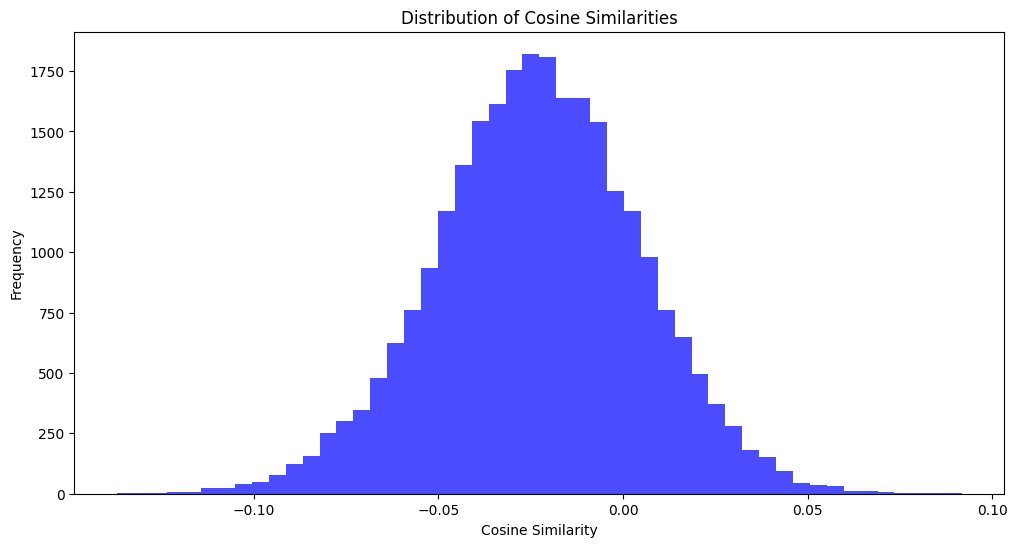

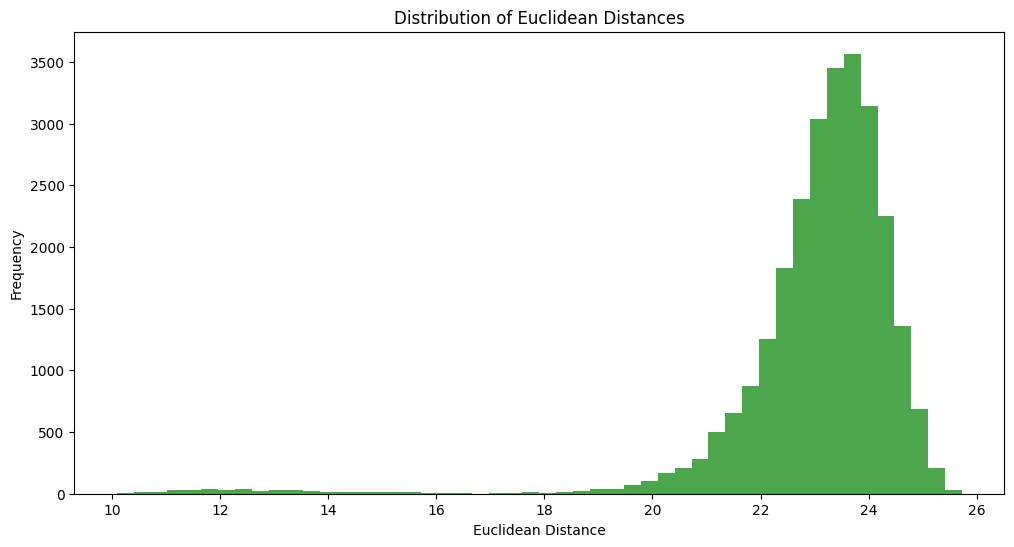

In [11]:
import matplotlib.pyplot as plt

# Extract cosine similarities and Euclidean distances
cosine_similarities = [metrics['cosine_similarity'] for metrics in results.values()]
euclidean_distances = [metrics['euclidean_distance'] for metrics in results.values()]

# Plot histogram for cosine similarities
plt.figure(figsize=(12, 6))
plt.hist(cosine_similarities, bins=50, color="blue", alpha=0.7)
plt.title("Distribution of Cosine Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

# Plot histogram for Euclidean distances
plt.figure(figsize=(12, 6))
plt.hist(euclidean_distances, bins=50, color="green", alpha=0.7)
plt.title("Distribution of Euclidean Distances")
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")
plt.show()

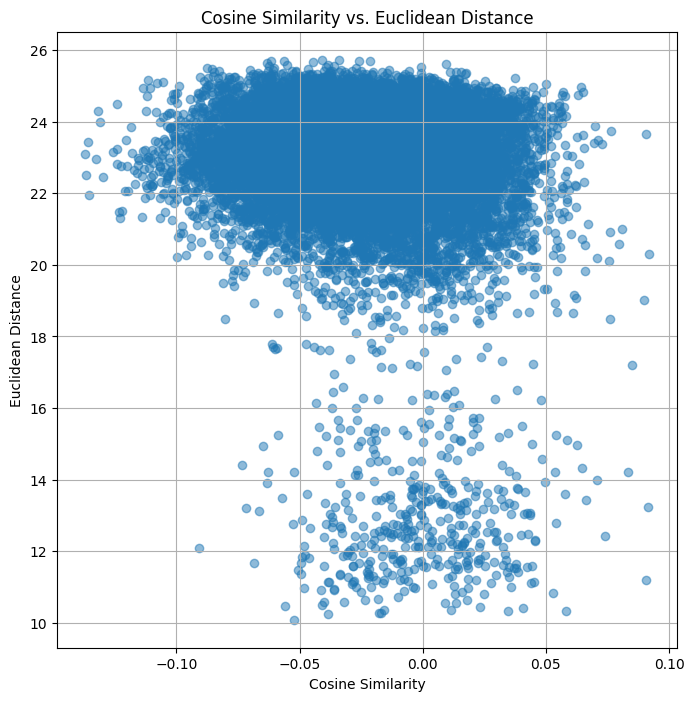

In [12]:
# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(cosine_similarities, euclidean_distances, alpha=0.5)
plt.title("Cosine Similarity vs. Euclidean Distance")
plt.xlabel("Cosine Similarity")
plt.ylabel("Euclidean Distance")
plt.grid(True)
plt.show()

In [10]:
common_cdr.head()

,TCR_name,TRBV,TRBJ,TRB_CDR3,TRBC,Epitope,MHC,Binding,task
1,2,TRBV5-1,TRBJ1-3,CASSLDSQSSGNTIYF,NaN,RAKFKQLL,HLA-B,1,NaN
9,10,TRBV29-1,TRBJ2-7,CSVSWDEGYEQYF,NaN,IVTDFSVIK,HLA-A,1,NaN
13,14,TRBV10-1,TRBJ1-1,CASRFSPGENTEAFF,NaN,QYDPVAALF,HLA-A,1,NaN
27,28,TRBV6-1,TRBJ2-3,CASSRDSALWISTDTQYF,NaN,ELAGIGILTV,HLA-A,1,NaN
63,64,TRBV6-5,TRBJ1-2,CASSYQTGTGTYGYTF,NaN,FLKEKGGL,HLA-B,1,NaN


In [12]:
common_epi.head()

,TCR_name,TRBV,TRBJ,TRB_CDR3,TRBC,Epitope,MHC,Binding,task
0,1,TRBV4-1,TRBJ2-1,CASSQETGSYEQFF,NaN,RPPIFIRRL,HLA-B,1,NaN
1,2,TRBV5-1,TRBJ1-3,CASSLDSQSSGNTIYF,NaN,RAKFKQLL,HLA-B,1,NaN
3,4,TRBV16,TRBJ2-1,CASSQSGVGNEQFF,NaN,KLGGALQAK,HLA-A,1,NaN
4,5,TRBV5-1,TRBJ1-4,CASSGTGTSAFATNEKLFF,NaN,KLGGALQAK,HLA-A,1,NaN
5,6,TRBV27,TRBJ1-2,CASSPGTGASGYTF,NaN,AVFDRKSDAK,HLA-A,1,NaN


In [6]:
len(common_cdr)

4904

In [7]:
len(df_pa)

251686

In [9]:
len(common_epi)

85451

In [3]:
df_pa.head()

,TCR_name,TRBV,TRBJ,TRB_CDR3,TRBC,Epitope,MHC,Binding,task
0,1,TRBV4-1,TRBJ2-1,CASSQETGSYEQFF,NaN,RPPIFIRRL,HLA-B,1,NaN
1,2,TRBV5-1,TRBJ1-3,CASSLDSQSSGNTIYF,NaN,RAKFKQLL,HLA-B,1,NaN
2,3,TRBV6-1,TRBJ1-6,CASSEWVFWSSYNSPLHF,NaN,VYALIAGATL,HLA-A,1,NaN
3,4,TRBV16,TRBJ2-1,CASSQSGVGNEQFF,NaN,KLGGALQAK,HLA-A,1,NaN
4,5,TRBV5-1,TRBJ1-4,CASSGTGTSAFATNEKLFF,NaN,KLGGALQAK,HLA-A,1,NaN


In [4]:
df_pm.head()

,CDR3.beta,Epitope,Label
0,CASSPGQGAPNEQFF,AVFDRKSDAK,1
1,CASSQVLDRGFYEQYF,KLGGALQAK,1
2,CASSTLRDSREKLF,EIYKRWII,1
3,CASQYTQGPGSGYTF,KLGGALQAK,1
4,CASYFFALFTDTQYF,VVMSWAPPV,1


In [12]:
import pickle

# Define the path
save_path = "/home/ubuntu/PA-Cancer-Immunotherapy/GNN/models/IEDB/IEDB_embeddings.pkl"

# Save seq_embs to the path
with open(save_path, "wb") as f:
    pickle.dump(final_embeddings, f)

print(f"seq_embs saved to {save_path}")


seq_embs saved to /home/ubuntu/PA-Cancer-Immunotherapy/GNN/models/IEDB/IEDB_embeddings.pkl


In [4]:
# analyse/compare embeddings 

In [2]:
# allele embeddings:
import pickle

path = "/home/ubuntu/PA-Cancer-Immunotherapy/GNN/models/PA/allele_embeddings.pkl"
# Load the .pkl file
with open(path, 'rb') as f:
    embeddings = pickle.load(f)

# Check the type of the loaded object
print("Type of the object:", type(embeddings))

# Explore the contents of the file
# If it's a dictionary, you can inspect keys and sample values
if isinstance(embeddings, dict):
    print("Number of keys:", len(embeddings))
    print("First few keys:", list(embeddings.keys())[:5])
    print("Sample value for the first key:", embeddings[list(embeddings.keys())[0]])
    
# If it's a list, inspect the first few elements
elif isinstance(embeddings, list):
    print("Number of elements:", len(embeddings))
    print("First few elements:", embeddings[:5])

# If it's a numpy array or other data structure, inspect its shape
elif hasattr(embeddings, 'shape'):
    print("Shape of the data:", embeddings.shape)

# Print a summary or explore further depending on the structure
print("Summary of the loaded data:", embeddings)


Type of the object: <class 'numpy.ndarray'>
Shape of the data: (59798, 768)
Summary of the loaded data: [[-2.69878507e-02 -1.38867006e-01  2.54617393e-01 ...  5.13641462e-02
  -1.99219380e-02  9.98317599e-02]
 [-2.17106249e-02 -1.38666481e-01  2.49028519e-01 ...  6.25600219e-02
  -1.55647174e-02  1.05816066e-01]
 [-2.16037575e-02 -1.38700545e-01  2.54984200e-01 ...  4.91954386e-02
  -1.23612554e-04  1.07337222e-01]
 ...
 [-8.59303102e-02 -1.31459206e-01  2.22138941e-01 ...  8.15643743e-02
  -1.54326335e-04  1.03523090e-01]
 [-3.20299715e-02 -1.20127551e-01  2.33830780e-01 ...  5.04595637e-02
   2.82946578e-03  8.62756297e-02]
 [-7.48625174e-02 -1.32738456e-01  2.24236473e-01 ...  8.36136937e-02
  -1.33908046e-02  9.17134732e-02]]


In [3]:
embeddings[1,:10]

array([-0.02171062, -0.13866648,  0.24902852,  0.00636786, -0.03938118,
        0.20179759, -0.01343466,  0.03972027,  0.03274158,  0.1899293 ],
      dtype=float32)

In [5]:
# other 'original' embeddings:  pMTnet

path = "/home/ubuntu/PA-Cancer-Immunotherapy/GNN/models/pMTnet/pMTnet_embeddings.pkl"
# Load the .pkl file
with open(path, 'rb') as f:
    embeddings = pickle.load(f)

# Check the type of the loaded object
print("Type of the object:", type(embeddings))



Type of the object: <class 'dict'>
Number of keys: 29823
First few keys: ['CASSFGGLDEQFF', 'CASSPLLQGNTEAFF', 'CILDNNNDMRF', 'CASSIGPALNTEAFFG', 'CASSPEGPIYNEQFF']
<class 'numpy.ndarray'>


In [ ]:
# check length of allele embeddings and allele file. If equal length => make dictionary TCR:value

In [6]:
#  data_for_inference/allele/beta/test.tsv
import pandas as pd

file_path = "../data_for_inference/allele/beta/test.tsv"

df = pd.read_csv(file_path, sep='\t')


In [7]:
df.head()

,TCR_name,TRBV,TRBJ,TRB_CDR3,TRBC,Epitope,MHC,Binding,task
0,1,TRBV6-5*01,TRBJ2-7*01,CASSTWTVSYEQYF,NaN,RLRAEAQVK,HLA-A*03:01,1,TPP1
1,2,TRBV27*01,TRBJ2-7*01,CASSLGGEQYF,NaN,TMADLVYAL,HLA-A*02:01,1,TPP1
2,3,TRBV5-4,TRBJ2-7,CASSLGGPYEQYF,NaN,VQPTESIVRFPNITNLCPF,NaN,1,TPP1
3,4,TRBV9,TRBJ1-1,CASSLTGTEAFF,NaN,FLNGSCGSV,NaN,1,TPP1
4,5,TRBV28,TRBJ2-7,CASSFLSEQYF,NaN,MGYINVFAFPFTIYSL,NaN,1,TPP1


In [3]:
len(df)

59798

In [8]:
# correct embedding making it a dictionary (provisional) to try inference_pa.py

import pickle
import pandas as pd

# read both 
path_tcr = "../data_for_inference/allele/beta/test.tsv"
path_embedding = "../models/PA/allele_embeddings.pkl"

df = pd.read_csv(path_tcr, sep='\t')

# Load the .pkl file
with open(path_embedding, 'rb') as f:
    embeddings = pickle.load(f)

dictionary = {}

for index, row in df.iterrows():
    key = row['TRB_CDR3']  # Key from the DataFrame column
    value = embeddings[index]  # Value from the embeddings (assuming index alignment)
    dictionary[key] = value


# Define the path
save_path = "../models/PA/allele_t_embeddings.pkl"

# Save seq_embs to the path
with open(save_path, "wb") as f:
    pickle.dump(dictionary, f)

print(f"embeddings dictionary saved to {save_path}")


embeddings dictionary saved to ../models/PA/allele_t_embeddings.pkl


In [ ]:
# inferenc_pa is not working.
# check embedding file (e.g. for pMTnet) contains embeddings also for the epitopes in the e.g. pMTnet StrictTCR_fold_0.csv
# 

In [2]:
path_emb = "/home/ubuntu/PA-Cancer-Immunotherapy/GNN/models/pMTnet/pMTnet_embeddings.pkl"
# Load the .pkl file
with open(path_emb, 'rb') as f:
    embeddings = pickle.load(f)

paths = []
for i in range(5):
    path_f = f"/home/ubuntu/PA-Cancer-Immunotherapy/GNN/processed_data/pMTnet/StrictTCR/StrictTCR_fold_{i}.csv"
    paths.append(path_f)

df = pd.read_csv(paths[0])

In [4]:
len(embeddings['AVFDRKSDAK'])

768

In [13]:
# checked: Epitopes are also in embeddings
count_is = 0
count_is_not = 0
# Iterate through the DataFrame
for index, row in df.iterrows():
    key = row['Epitope']  # Extract the key from the column
    if key in embeddings:  # Check if the key is in the dictionary
        count_is += 1
    else:
        count_is_not += 1

print(count_is, count_is_not)

69003 0


In [11]:
df.head()

,CDR3.beta,Epitope,Label
0,CASSPGQGAPNEQFF,AVFDRKSDAK,1
1,CASSQVLDRGFYEQYF,KLGGALQAK,1
2,CASSTLRDSREKLF,EIYKRWII,1
3,CASQYTQGPGSGYTF,KLGGALQAK,1
4,CASYFFALFTDTQYF,VVMSWAPPV,1


In [ ]:
# HERE BELOW: MORE EXPLORATIONS

In [14]:
df_tcrs = pd.read_csv('TCRpeg/tcrpeg/data/TCRs_train.csv', compression='gzip')
df_tcrs.head()

,seq,v,j
0,CASSLTFGNTIYF,TRBV5-8,TRBJ1-3
1,CATGFPNYGYTF,TRBV28,TRBJ1-2
2,CASSLGSGDYNEQFF,TRBV7-6,TRBJ2-1
3,CASSTHTVTDTQYF,TRBV7-9,TRBJ2-3
4,CSVVRGLNEQFF,TRBV29-1,TRBJ2-1


In [9]:
#create the TCRpeg class
model = TCRpeg(hidden_size=64,num_layers = 3,load_data=True,embedding_path='TCRpeg/tcrpeg/data/embedding_32.txt',path_train=tcrs_train)
#create the TCRpeg model. 
model.create_model()

Have loaded the data, total training seqs : 100000


In [11]:
tcrs_train = pd.read_csv('TCRpeg/tcrpeg/data/TCRs_train.csv',compression='gzip')['seq'].values


AttributeError: 'numpy.ndarray' object has no attribute 'head'

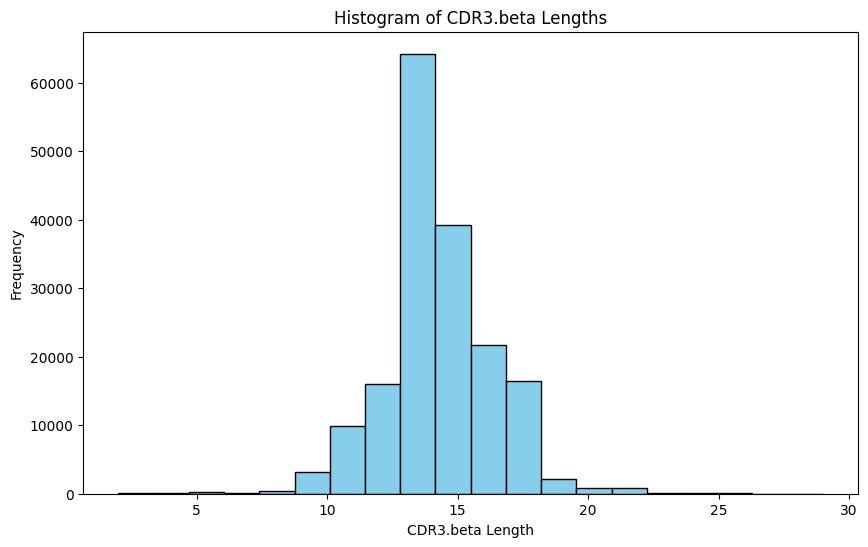

In [8]:
import matplotlib.pyplot as plt

# Example DataFrame
# df = pd.DataFrame({'CDR3.beta': ['CASSLGGTDTQYF', 'CASRRGQETQYF', 'CASSPRRGETQYF']})

# Calculate the length of each string in the 'CDR3.beta' column
df['CDR3_length'] = df['CDR3.beta'].apply(len)

# Plot a histogram of these lengths
plt.figure(figsize=(10, 6))
plt.hist(df['CDR3_length'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('CDR3.beta Length')
plt.ylabel('Frequency')
plt.title('Histogram of CDR3.beta Lengths')
plt.show()